# Import libraries

In [1]:
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import matplotlib.ticker as pltickerl
import cartopy.crs as ccrs
import cartopy.feature as cf
import seaborn as sns
from pandas.plotting import lag_plot, autocorrelation_plot
from pandas import DataFrame
from statsmodels.graphics.tsaplots import plot_acf
import datetime
import warnings

# Functions

Function StdDev(data)

Calculates the standard deviation of each column (ensemble member) to the group mean (i.e., the mean of the flat array of all ensemble member data)

In [2]:
def StdDev(data):
    suma = 0
    for x in data: 
        suma += ((x - 290.15796)**2)  # every iteration subtracts the mean value (which we have calculated as 290.15796) from every [x] element of a list and then raises to the second power [**2]
    return ((suma/(len(data)-1))**0.5) # then divide by n-1 [len(data)-1] and extract the root of 2 [**0.5]

Function major_city_plot(lat, lon)

Makes a series of a chosen UK city's yearly average temperature.

Must provide lat and lon coordinates of UK city, for which it will use the nearest coordinates in Xarray.

In [3]:
def major_city_plot(lat, lon):
    ##First, we need to select only the data for the UK city location in Xarray
    city_datasets = []
    
    for i in datasets:
        to_add = i.sel(lat=lat, lon=lon, method="nearest")
        city_datasets.append(to_add)
    
    ##Just label variable of Datasets saved in array        
    city_datasets_label = []
    
    ## Selecting only the TREFMXAV_U variable
    for i in city_datasets:
        to_add = i.TREFMXAV_U
        city_datasets_label.append(to_add)
        
    ## Convert to dataframe and save to array   
    df_city_label = []
    
    ## Converting to pandas dataframe (no nan values for selected latitude/longitude because over land)
    for i in city_datasets_label:
        to_add = i.to_dataframe()
        to_add = to_add.drop(['lat', 'lon'], axis=1)
        df_city_label.append(to_add)
        
    ## Combining into one large dataset
    df_city_label_combined = pd.concat(df_city_label, axis=1)     ## axis=1 ensures it concatenates column-wise, not adding rows

    ## Renaming column as ensemble member number
    for i in range(31):
        string = str(i+3)
        df_city_label_combined.columns.values[i] = string
        
    ## Group by year and calculate mean 
    df_city_label_combined_mean = df_city_label_combined.groupby(df_city_label_combined.index.get_level_values('time').year).mean()
    ## the result is a dataframe with just 75 rows for each year between 2006-2080

    ## Take the mean across each row (i.e., all ensemble members for one year)
    city_yearly_mean = df_city_label_combined_mean.mean(axis=1)
    
    return city_yearly_mean

Function plot_year_season(member_time)

Grabs requested ensemble member and splits up by season to make seasonal map plot.

In [4]:
def plot_year_season(member_time):
    ##Extract the season
    seasons = member_time['time'].dt.season
    ## Group data (label variable) by season
    seasonal_groupby = member_time.TREFMXAV_U.groupby(seasons)
    ## Find the mean temp by year
    seasonal_mean_temps = seasonal_groupby.mean()
    ## (Xarray likes to be lazy,) compute the result
    seasonal_mean_temps_compute = seasonal_mean_temps.compute()

                                        ##Season DJF and JJA
    fg = seasonal_mean_temps_compute.isel(season=[0,1]).plot(
        col="season",
        transform=ccrs.PlateCarree(),  # remember to provide this!
        subplot_kws={"projection": ccrs.LambertConformal(central_longitude=-3, central_latitude=54)},
        #cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
        robust=True,
        size=6,
        aspect=0.8,
        vmin=284, vmax=300,
    )

    ##lets add a coastline to each axis 
    fg.map(lambda: plt.gca().coastlines())
    
    return fg

Function merge_corr(num1, num2)

Grabs two different ensemble member's data, calculates their correlation matrix, then merges them together (so that each half of the matrix represents a different member)

In [5]:
def merge_corr(num1, num2):
    ##Isolating data from Ensemble
    ensemble1 = df_full.loc[df_full['Ensemble_num'] == num1]
    ensemble2 = df_full.loc[df_full['Ensemble_num'] == num2]
    ##Re-set index
    ensemble1 = ensemble1.reset_index()
    ensemble2 = ensemble2.reset_index()
    ##Dropping 'Ensemble_num' and 'time' and re-ordering so that label variable first column
    ensemble1 = ensemble1[['TREFMXAV_U', 'lat', 'lon','Day_of_year', 'Year', 'FLNS', 
                         'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT']]
    ensemble2 = ensemble2[['TREFMXAV_U', 'lat', 'lon','Day_of_year', 'Year', 'FLNS', 
                         'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT']]

    ##Calculating correlation matrix
    corr1 = ensemble1.corr(method='spearman')
    corr2 = ensemble2.corr(method='spearman')
    
    ##Calculating correlation matrix
    mask1 = np.triu(np.ones_like(corr1, dtype=bool))
    mask2 = np.tril(np.ones_like(corr2, dtype=bool))

    fig, ax = plt.subplots(figsize=(11, 9))

    sns.heatmap(corr1, mask=mask1, annot=True, fmt=".3f",
                cmap='viridis', 
                vmax=.9, vmin=-.3,
                square=True, linewidths=.5, 
                cbar=False,
                ax=ax)
    sns.heatmap(corr2, mask=mask2, annot=True, fmt=".3f",
                cmap='viridis', 
                vmax=.9, vmin=-.3,
                square=True, linewidths=.5, 
                cbar=True, ##only need one colour bar
                cbar_kws={"shrink": .85, 
                "label":"Spearman's correlation"}, ax=ax)

Function lag_label(df, num_lags)

Updates dataset with lagged features for label variable, for any defined number of lag days.

In [6]:
def lag_label(df, num_lags):
    for col in label_col:
        for i in range(1, num_lags+1):
            ##Make lagged column variable using shifted values
            df[col+f'_lag_{i}'] = df.groupby(['lat','lon'])[col].shift(i)
            
    df.dropna(inplace=True)

    return df

Function lag_pred(df, num_lags)

Creates X number of lag columns for predictor variables.

In [2]:
def lag_pred(df, num_lags):
    for col in feature_cols:
        for i in range(1, num_lags+1):
            ##Make lagged column variable using shifted values
            df[col+f'_lag_{i}'] = df.groupby(['lat','lon'])[col].shift(i)
            
    df.dropna(inplace=True)
    
    return df

# Comparing label variable for different ensemble members

## Load in netCDF raw files

### Load into local environment

In [2]:
## OPENING 2 .nc files of each ensemble member (from 003 to 033), whilst naming them (with previously printed names) 
## in local environment as, e.g., ensemble3_0_2 and ensemble3_352_360

## Array which we will fill with each Dataset
temp_datasets = []

for i in range(31):
    ## Ensemble number starts from 003
    ensemble_member = 3+i
    ## Need to convert to string for next steps
    ensemble_member_str = str(ensemble_member)
    if ensemble_member<=9:
        for j in range(1):
            dataset_name = "ensemble"+ensemble_member_str+"_0_2"
            dataset_name = xr.open_dataset("00"+ensemble_member_str+"_2006_2080_0_2.nc")
            ## Appending opened Dataset to array
            temp_datasets.append(dataset_name)
        for k in range(1):
            dataset_name = "ensemble"+ensemble_member_str+"_352_360"
            dataset_name = xr.open_dataset("00"+ensemble_member_str+"_2006_2080_352_360.nc")
            temp_datasets.append(dataset_name)
    else:
        for j in range(1):
            dataset_name = "ensemble"+ensemble_member_str+"_0_2"
            dataset_name = xr.open_dataset("0"+ensemble_member_str+"_2006_2080_0_2.nc")
            temp_datasets.append(dataset_name)
        for k in range(1):
            dataset_name = "ensemble"+ensemble_member_str+"_352_360"
            dataset_name = xr.open_dataset("0"+ensemble_member_str+"_2006_2080_352_360.nc")
            temp_datasets.append(dataset_name)

### Combine and re-set longitude co-ordinates

In [3]:
## Re-setting longitute coordinates
## Loop through each odd i-th Dataset in array
for i in range(62):
    if i%2==1:     ## means when i is odd
        ## Change coordinates
        temp_datasets[i] = temp_datasets[i].assign_coords(lon=temp_datasets[i].lon - 360)
    else:
        continue

## Combining together
## Full Datasets saved in an array
datasets = []

## Loop through each odd i-th Dataset in array
for i in range(62):
    if i%2==0:     ## means when i is even
        to_add = temp_datasets[i].combine_first(temp_datasets[(i+1)])
        datasets.append(to_add)

## Combined data frame of just label variable and all ensemble members

#### <font color=orange>Full simulation period (2006-2080)</font>

In [4]:
## Just label variable of Datasets saved in array        
datasets_label = []

## Selecting only the TREFMXAV_U variable
for i in datasets:
    to_add = i.TREFMXAV_U
    datasets_label.append(to_add)

## Just label variable of Dataframe saved in array        
df_label = []    
    
## Converting to pandas dataframe while dropping null values
for i in datasets_label:
    to_add = i.to_dataframe().dropna()
    df_label.append(to_add)
    
## Combining into one large dataset
df_label_combined = pd.concat(df_label, axis=1)     ## axis=1 ensures it concatenates column-wise, not adding rows

## Renaming column as ensemble member number
for i in range(31):
    string = str(i+3)
    df_label_combined.columns.values[i] = string

df_label_combined

3           4           5  \
time                lat       lon                                         
2006-01-02 00:00:00 49.476440 -1.25  283.678986  286.380432  283.247620   
                               0.00  283.351013  286.786377  280.677002   
                               1.25  282.187378  286.705475  279.488251   
                    50.418850 -5.00  284.443939  286.053467  285.556488   
                              -3.75  284.329865  286.068848  285.439606   
...                                         ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  284.948883  281.218506  285.336823   
                              -3.75  285.162354  280.901093  285.578430   
                              -2.50  285.853149  281.899109  285.697296   
                              -1.25  285.870361  282.441071  285.875977   
                    58.900524 -3.75  285.378082  282.256317  286.062103   

                                              6           7           8  \
time                lat       lon                                         
2006-01-02 00:00:00 49.476440 -1.25  280.098328  283.666443  285.882904   
                               0.00  280.960754  283.172455  284.227875   
                               1.25  281.546082  282.857300  283.469086   
                    50.418850 -5.00  285.565002  284.906708  286.456604   
                              -3.75  284.542419  284.143890  286.392731   
...                                         ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  282.784576  281.768890  280.786346   
                              -3.75  278.516418  280.328918  279.068298   
                              -2.50  280.333801  281.096985  279.864868   
                              -1.25  281.781708  281.614929  280.432617   
                    58.900524 -3.75  281.919281  282.201508  281.685608   

                                              9          10          11  \
time                lat       lon                                         
2006-01-02 00:00:00 49.476440 -1.25  283.336853  283.250763  284.966492   
                               0.00  283.111511  284.962250  284.688538   
                               1.25  282.412079  284.307800  285.085907   
                    50.418850 -5.00  287.222748  285.053253  285.805267   
                              -3.75  286.416138  285.039612  285.525665   
...                                         ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  285.741821  280.454834  284.396942   
                              -3.75  285.625793  278.299988  283.615051   
                              -2.50  286.279144  280.353363  283.555145   
                              -1.25  286.131897  281.266418  284.338623   
                    58.900524 -3.75  286.424194  281.122253  284.768890   

                                             12  ...          24          25  \
time                lat       lon                ...                           
2006-01-02 00:00:00 49.476440 -1.25  286.850952  ...  287.615112  282.841766   
                               0.00  286.984955  ...  287.800537  282.014679   
                               1.25  287.158722  ...  287.535339  280.992035   
                    50.418850 -5.00  286.614014  ...  288.697662  285.358246   
                              -3.75  286.771484  ...  288.610962  284.482361   
...                                         ...  ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  283.096985  ...  283.711578  282.999298   
                              -3.75  282.203522  ...  282.915558  282.262085   
                              -2.50  283.404083  ...  283.909149  283.073730   
                              -1.25  284.695435  ...  284.747375  283.776398   
                    58.900524 -3.75  283.591400  ...  284.589111  283.603088   

                                             26          27          28  \
ti

#### <font color=green>Just "end of century" (2071-2080)</font>

In [5]:
## Try and do the above cell automated...
datasets_label_end_of_century = []

## Selecting only the TREFMXAV_U variable and dates between 2071 - 2080
for i in datasets:
    to_add = i.TREFMXAV_U.sel(time=slice('2071','2080'))
    datasets_label_end_of_century.append(to_add)
    
df_label_end_of_century = []

## Converting to pandas dataframe while dropping null values
for i in datasets_label_end_of_century:
    to_add = i.to_dataframe().dropna()
    df_label_end_of_century.append(to_add)
    
## Combining into one large dataset
df_end_of_century_label_combined = pd.concat(df_label_end_of_century, axis=1)     ## axis=1 ensures it concatenates column-wise, not adding rows

## Renaming column as ensemble member number
for i in range(31):
    string = str(i+3)
    df_end_of_century_label_combined.columns.values[i] = string

df_end_of_century_label_combined

3           4           5  \
time                lat       lon                                         
2071-01-01 00:00:00 49.476440 -1.25  289.565704  285.047485  288.559448   
                               0.00  289.269897  283.773132  288.875916   
                               1.25  287.941101  281.789368  288.565674   
                    50.418850 -5.00  286.998230  285.645935  288.310486   
                              -3.75  288.305786  285.613678  288.761139   
...                                         ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  284.948883  281.218506  285.336823   
                              -3.75  285.162354  280.901093  285.578430   
                              -2.50  285.853149  281.899109  285.697296   
                              -1.25  285.870361  282.441071  285.875977   
                    58.900524 -3.75  285.378082  282.256317  286.062103   

                                              6           7           8  \
time                lat       lon                                         
2071-01-01 00:00:00 49.476440 -1.25  283.896332  288.140686  286.441589   
                               0.00  283.257477  286.669708  284.738525   
                               1.25  282.809235  283.245422  284.044800   
                    50.418850 -5.00  288.291718  288.469421  287.764893   
                              -3.75  287.667603  288.917603  287.394623   
...                                         ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  282.784576  281.768890  280.786346   
                              -3.75  278.516418  280.328918  279.068298   
                              -2.50  280.333801  281.096985  279.864868   
                              -1.25  281.781708  281.614929  280.432617   
                    58.900524 -3.75  281.919281  282.201508  281.685608   

                                              9          10          11  \
time                lat       lon                                         
2071-01-01 00:00:00 49.476440 -1.25  287.014923  288.065186  285.390350   
                               0.00  286.688049  287.314697  286.261414   
                               1.25  286.295563  286.576996  286.328033   
                    50.418850 -5.00  285.787537  288.374084  288.519073   
                              -3.75  286.116974  288.460663  287.484283   
...                                         ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  285.741821  280.454834  284.396942   
                              -3.75  285.625793  278.299988  283.615051   
                              -2.50  286.279144  280.353363  283.555145   
                              -1.25  286.131897  281.266418  284.338623   
                    58.900524 -3.75  286.424194  281.122253  284.768890   

                                             12  ...          24          25  \
time                lat       lon                ...                           
2071-01-01 00:00:00 49.476440 -1.25  286.546112  ...  289.759857  284.336975   
                               0.00  283.821838  ...  289.866333  283.868225   
                               1.25  282.579041  ...  289.327515  283.233765   
                    50.418850 -5.00  287.346069  ...  289.567566  284.826050   
                              -3.75  287.324432  ...  289.347229  284.868896   
...                                         ...  ...         ...         ...   
2080-12-31 00:00:00 57.958115 -6.25  283.096985  ...  283.711578  282.999298   
                              -3.75  282.203522  ...  282.915558  282.262085   
                              -2.50  283.404083  ...  283.909149  283.073730   
                              -1.25  284.695435  ...  284.747375  283.776398   
                    58.900524 -3.75  283.591400  ...  284.589111  283.603088   

                                             26          27          28  \
ti

# Load in full Pandas data frame

In [2]:
df_full = pd.read_parquet('Final full dataset.parquet', engine = 'pyarrow')
display(df_full)

Ensemble_num  TREFMXAV_U  Day_of_year  Year  \
time       lat       lon                                                  
2006-01-02 49.476440 -1.25             3   283.67900            2  2006   
                      0.00             3   283.35100            2  2006   
                      1.25             3   282.18738            2  2006   
           50.418850 -5.00             3   284.44394            2  2006   
                     -3.75             3   284.32986            2  2006   
...                                  ...         ...          ...   ...   
2080-12-31 57.958115 -6.25            33   281.49220          366  2080   
                     -3.75            33   280.94980          366  2080   
                     -2.50            33   281.72986          366  2080   
                     -1.25            33   282.41420          366  2080   
           58.900524 -3.75            33   282.37146          366  2080   

                                 FLNS       FSNS         PRECT          PRSN  \
time       lat       lon                                                       
2006-01-02 49.476440 -1.25  78.309050  49.704235  1.521918e-08  2.044216e-17   
                      0.00  60.172768  43.689503  1.322234e-08  1.171104e-17   
                      1.25  32.727840  28.623762  1.178051e-09  5.449920e-21   
           50.418850 -5.00  78.301250  44.980167  1.131585e-08  8.991746e-22   
                     -3.75  82.156400  46.794003  8.339057e-09  1.546433e-20   
...                               ...        ...           ...           ...   
2080-12-31 57.958115 -6.25  52.250000   5.492432  8.324969e-08  6.823153e-13   
                     -3.75  27.625000   5.855469  8.928873e-08  2.512888e-08   
                     -2.50  59.250000   9.607666  8.084498e-08  1.265862e-13   
                     -1.25  75.000000  13.924561  5.770107e-08  2.130295e-15   
           58.900524 -3.75  59.000000   8.464844  6.922528e-08  5.069990e-14   

                                QBOT     TREFHT      UBOT      VBOT  
time       lat       lon                                             
2006-01-02 49.476440 -1.25  0.005410  281.38837  5.109643 -0.435289  
                      0.00  0.005415  279.85904  4.190400  0.893759  
                      1.25  0.005343  278.85187  3.444478  1.583298  
           50.418850 -5.00  0.005035  283.07712  6.209209 -3.468437  
                     -3.75  0.005278  282.47390  5.486755 -2.518895  
...                              ...        ...       ...       ...  
2080-12-31 57.958115 -6.25  0.004242  280.00000  3.484375 -1.656250  
                     -3.75  0.004303  276.25000  2.156250  1.687500  
                     -2.50  0.004547  279.12500  3.687500  2.812500  
                     -1.25  0.004395  281.00000  6.125000  3.125000  
           58.900524 -3.75  0.004120  280.12500  4.062500 -1.070312  

[44126888 rows x 12 columns]

# Statistical Assessment

## Calculating group mean and median (all ensemble members and locations)

In [13]:
## Calculate mean temperature value (across all ensemble members for the period 2071-2080)
## Convert above Pandas dataframe to numpy array and calculate mean across whole array
arr1 = df_end_of_century_label_combined.to_numpy()

print("The mean temperature (across all ensemble members for the period 2071-2080) is", np.mean(arr1))
print("The median temperature (across all ensemble members for the period 2071-2080) is", np.median(arr1))

The mean temperature (across all ensemble members for the period 2071-2080) is 290.15796
The median temperature (across all ensemble members for the period 2071-2080) is 289.40356


## Calculating standard deviation column-wise (i.e., SD within each ensemble member)

In [14]:
##Calculates standard deviation of each column (ensemble member)
##Sort in descending order to see which members have greatest spread
print("Standard deviation column-wise (i.e., SD within each ensemble member):")
df_end_of_century_label_combined.std().sort_values(ascending=False)

Standard deviation column-wise (i.e., SD within each ensemble member):


31    5.780656
16    5.754562
32    5.694990
19    5.691830
6     5.688623
21    5.680367
24    5.674302
3     5.653193
9     5.648077
29    5.624318
17    5.623703
22    5.621846
11    5.608943
26    5.578613
7     5.572831
30    5.545435
23    5.544237
25    5.525359
28    5.522819
12    5.519093
15    5.508666
10    5.498569
27    5.496078
20    5.492665
33    5.470610
14    5.436076
18    5.410434
4     5.406237
13    5.402510
8     5.397760
5     5.267644
dtype: float32

## Calculating standard deviation to group mean (of all ensemble members)

In [15]:
print("Standard deviation compared to the group mean:")
df_end_of_century_label_combined.apply(StdDev)

Standard deviation compared to the group mean:


3     5.654391
4     5.406720
5     5.269235
6     5.695557
7     5.573391
8     5.402033
9     5.649131
10    5.499748
11    5.609373
12    5.526414
13    5.404427
14    5.446636
15    5.508733
16    5.759797
17    5.625007
18    5.411524
19    5.692109
20    5.492748
21    5.680597
22    5.628788
23    5.545708
24    5.677504
25    5.525468
26    5.578879
27    5.513647
28    5.523060
29    5.627410
30    5.547221
31    5.780785
32    5.703566
33    5.477309
dtype: float64

## Calculating the mean within each ensemble member (and seeing how this differs to the whole group mean)

In [16]:
##Calculating ensemble member mean
ensemble_mean = df_end_of_century_label_combined.mean(axis=0)
print("Ensemble member mean:")
display(ensemble_mean)

Ensemble member mean:


3     290.046661
4     290.224823
5     290.031372
6     290.437927
7     290.086273
8     289.945190
9     290.261444
10    290.049194
11    290.096680
12    289.874573
13    290.017883
14    289.820129
15    290.153625
16    290.401306
17    290.274597
18    290.053558
19    290.203491
20    290.165131
21    290.198853
22    290.435394
23    290.281952
24    290.346313
25    290.138824
26    290.115356
27    289.719116
28    290.116852
29    290.343079
30    290.020386
31    290.138153
32    290.469147
33    290.426910
dtype: float32

In [17]:
## Calculating the mean of each dataframe column and finding the difference between that and 
## the mean of the whole flat array
ensemble_mean = df_end_of_century_label_combined.mean(axis=0)
## 290.15796 is the whole group mean
ensemble_mean_diff = abs(ensemble_mean - 290.15796)
## Sort in descending order so that ensemble member with furthest mean printed first
print("Difference between member mean and group mean (in descending order):")
ensemble_mean_diff.sort_values(ascending=False)

Difference between member mean and group mean (in descending order):


27    0.438843
14    0.337830
32    0.311188
12    0.283386
6     0.279968
22    0.277435
33    0.268951
16    0.243347
8     0.212769
24    0.188354
29    0.185120
13    0.140076
30    0.137573
5     0.126587
23    0.123993
17    0.116638
3     0.111298
10    0.108765
18    0.104401
9     0.103485
7     0.071686
4     0.066864
11    0.061279
19    0.045532
26    0.042603
28    0.041107
21    0.040894
31    0.019806
25    0.019135
20    0.007172
15    0.004333
dtype: float32

## Calculating the median within each ensemble member (and seeing how this differs to the whole group mean)

In [18]:
##Calculating ensemble member median
ensemble_median = df_end_of_century_label_combined.median(axis=0)
print("Ensemble member median:")
display(ensemble_mean)

Ensemble member median:


3     290.046661
4     290.224823
5     290.031372
6     290.437927
7     290.086273
8     289.945190
9     290.261444
10    290.049194
11    290.096680
12    289.874573
13    290.017883
14    289.820129
15    290.153625
16    290.401306
17    290.274597
18    290.053558
19    290.203491
20    290.165131
21    290.198853
22    290.435394
23    290.281952
24    290.346313
25    290.138824
26    290.115356
27    289.719116
28    290.116852
29    290.343079
30    290.020386
31    290.138153
32    290.469147
33    290.426910
dtype: float32

In [19]:
## Calculating the difference to group median (column-wise)
## 289.40356 is the whole group median
ensemble_median_diff = abs(ensemble_median - 289.40356)
print("Difference between member median and group median (in descending order):")
ensemble_median_diff.sort_values(ascending=False)

Difference between member median and group median (in descending order):


27    0.401672
33    0.321777
22    0.270203
32    0.228912
16    0.214600
14    0.206940
31    0.177429
28    0.161224
26    0.154602
17    0.151276
3     0.135376
21    0.125580
4     0.120148
30    0.113647
12    0.112305
8     0.107483
23    0.094971
6     0.093140
11    0.089600
15    0.069519
20    0.066895
10    0.055359
5     0.045044
13    0.041992
29    0.041992
9     0.041412
7     0.030457
18    0.029053
24    0.022400
25    0.013916
19    0.001526
dtype: float32

## Min and Max temperature estimates (to find potentially "colder" and "hotter estimates")

In [20]:
##Group by ensemble number and report minimum temperature recorded (in ascending order)
print("Minimum recorded temperature per ensemble member (in ascending order):")
df_full.groupby('Ensemble_num')['TREFMXAV_U'].min().sort_values(ascending=True)

Minimum recorded temperature per ensemble member (in ascending order):


Ensemble_num
24    263.60922
10    264.45264
30    265.78372
22    266.87958
27    267.31396
6     267.89280
33    268.50390
4     268.55173
7     268.64093
31    268.65980
23    268.80792
32    268.86530
17    268.92340
19    269.06305
9     269.39658
21    269.42236
28    269.67767
14    269.84134
25    269.97626
13    270.22060
16    270.22797
8     270.38443
11    270.50394
26    270.77063
3     270.83540
18    270.86066
29    271.31110
12    271.53186
5     271.54156
15    271.54205
20    271.64798
Name: TREFMXAV_U, dtype: float64

In [21]:
##Group by ensemble number and report maximum temperature recorded (in descending order)
print("Maximum recorded temperature per ensemble member (in descending order):")
df_full.groupby('Ensemble_num')['TREFMXAV_U'].max().sort_values(ascending=False)

Maximum recorded temperature per ensemble member (in descending order):


Ensemble_num
14    320.00290
15    319.60892
12    318.71170
23    318.33987
33    318.11642
5     318.05050
22    317.87997
20    317.72120
16    317.45490
9     317.37848
31    317.24900
32    317.10410
24    316.77356
18    316.75348
27    316.64860
7     316.55130
29    316.52148
13    316.52000
10    316.38170
6     316.12173
17    316.07043
19    315.90400
28    315.65520
4     315.50867
11    315.35178
8     315.24005
26    315.14844
3     314.89417
25    314.69073
21    314.54233
30    314.28433
Name: TREFMXAV_U, dtype: float64

# Visualising member spread

## Box and Whisker plot

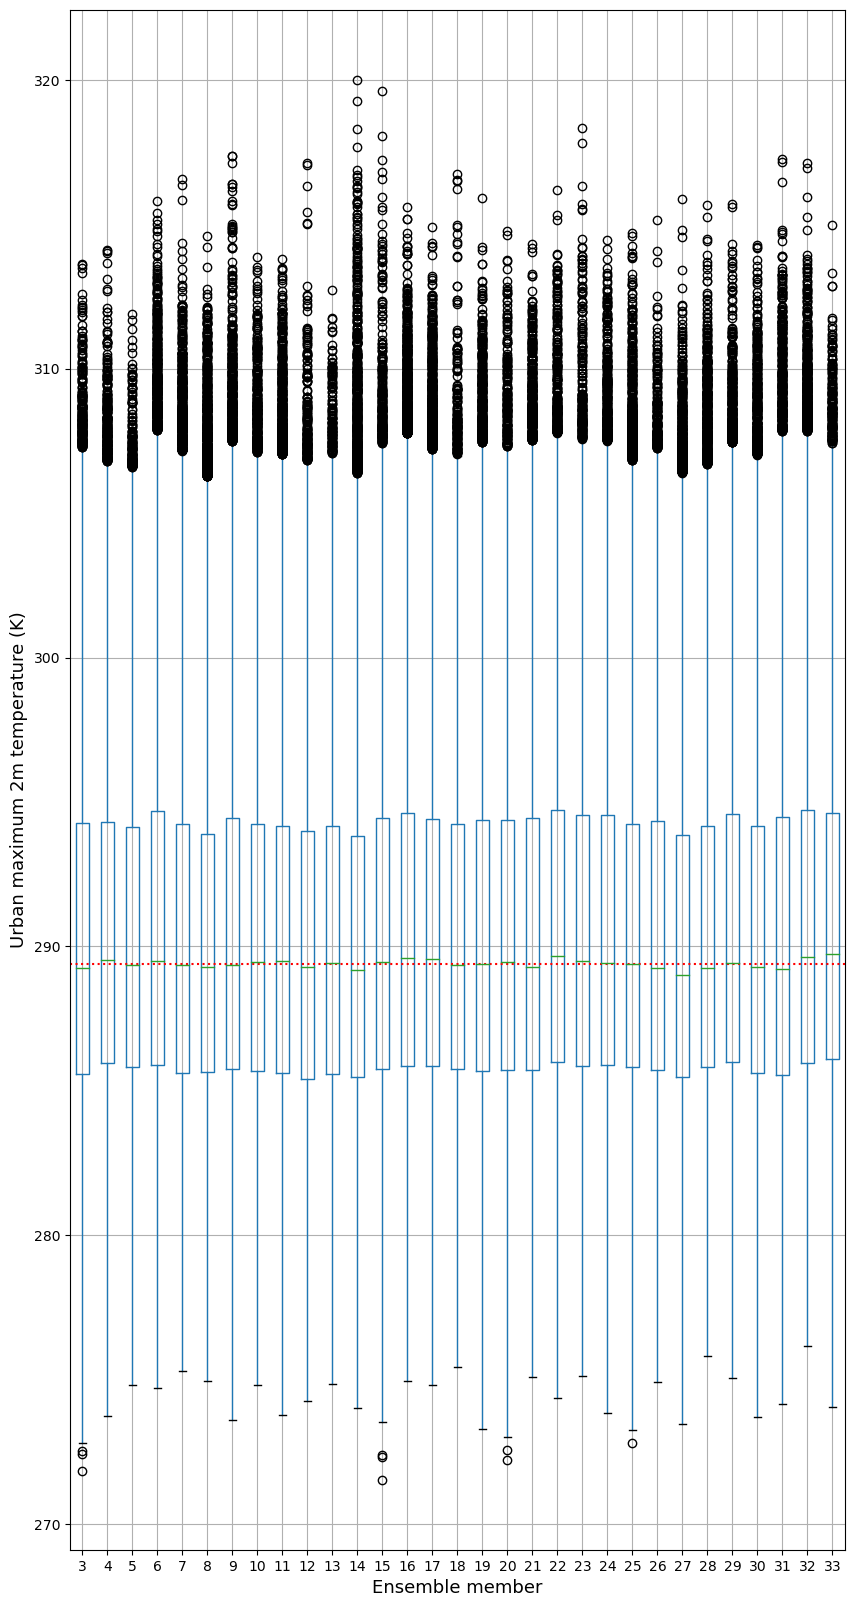

In [22]:
import matplotlib.pyplot as plt

## How to save to .png file in working directory
ax = df_end_of_century_label_combined.boxplot(figsize=(10,20))
## Adding axis titles
ax.set_ylabel("Urban maximum 2m temperature (K)", fontsize = 13)
ax.set_xlabel("Ensemble member", fontsize = 13)
## Adding red dashed line at whole flat array mean
#plt.axhline(y = 290.15796, color = 'r', linestyle = ':')
## Adding red dashed line at whole flat array median
plt.axhline(y = 289.40356, color = 'r', linestyle = ':')
## Saving figure to working directory as .png file
#ax.figure.savefig('Box and whisker ensemble members (2071-2080) with median line red.png')

## Histogram Distribution Plot

In [23]:
## Sub-titles to add to our subplots
titles = []

for i in range(31):
    ensemble_member = str(3+i)
    to_add = "Ensemble member "+ensemble_member
    titles.append(to_add)
    
#print("Subtitles:")
#display(titles)

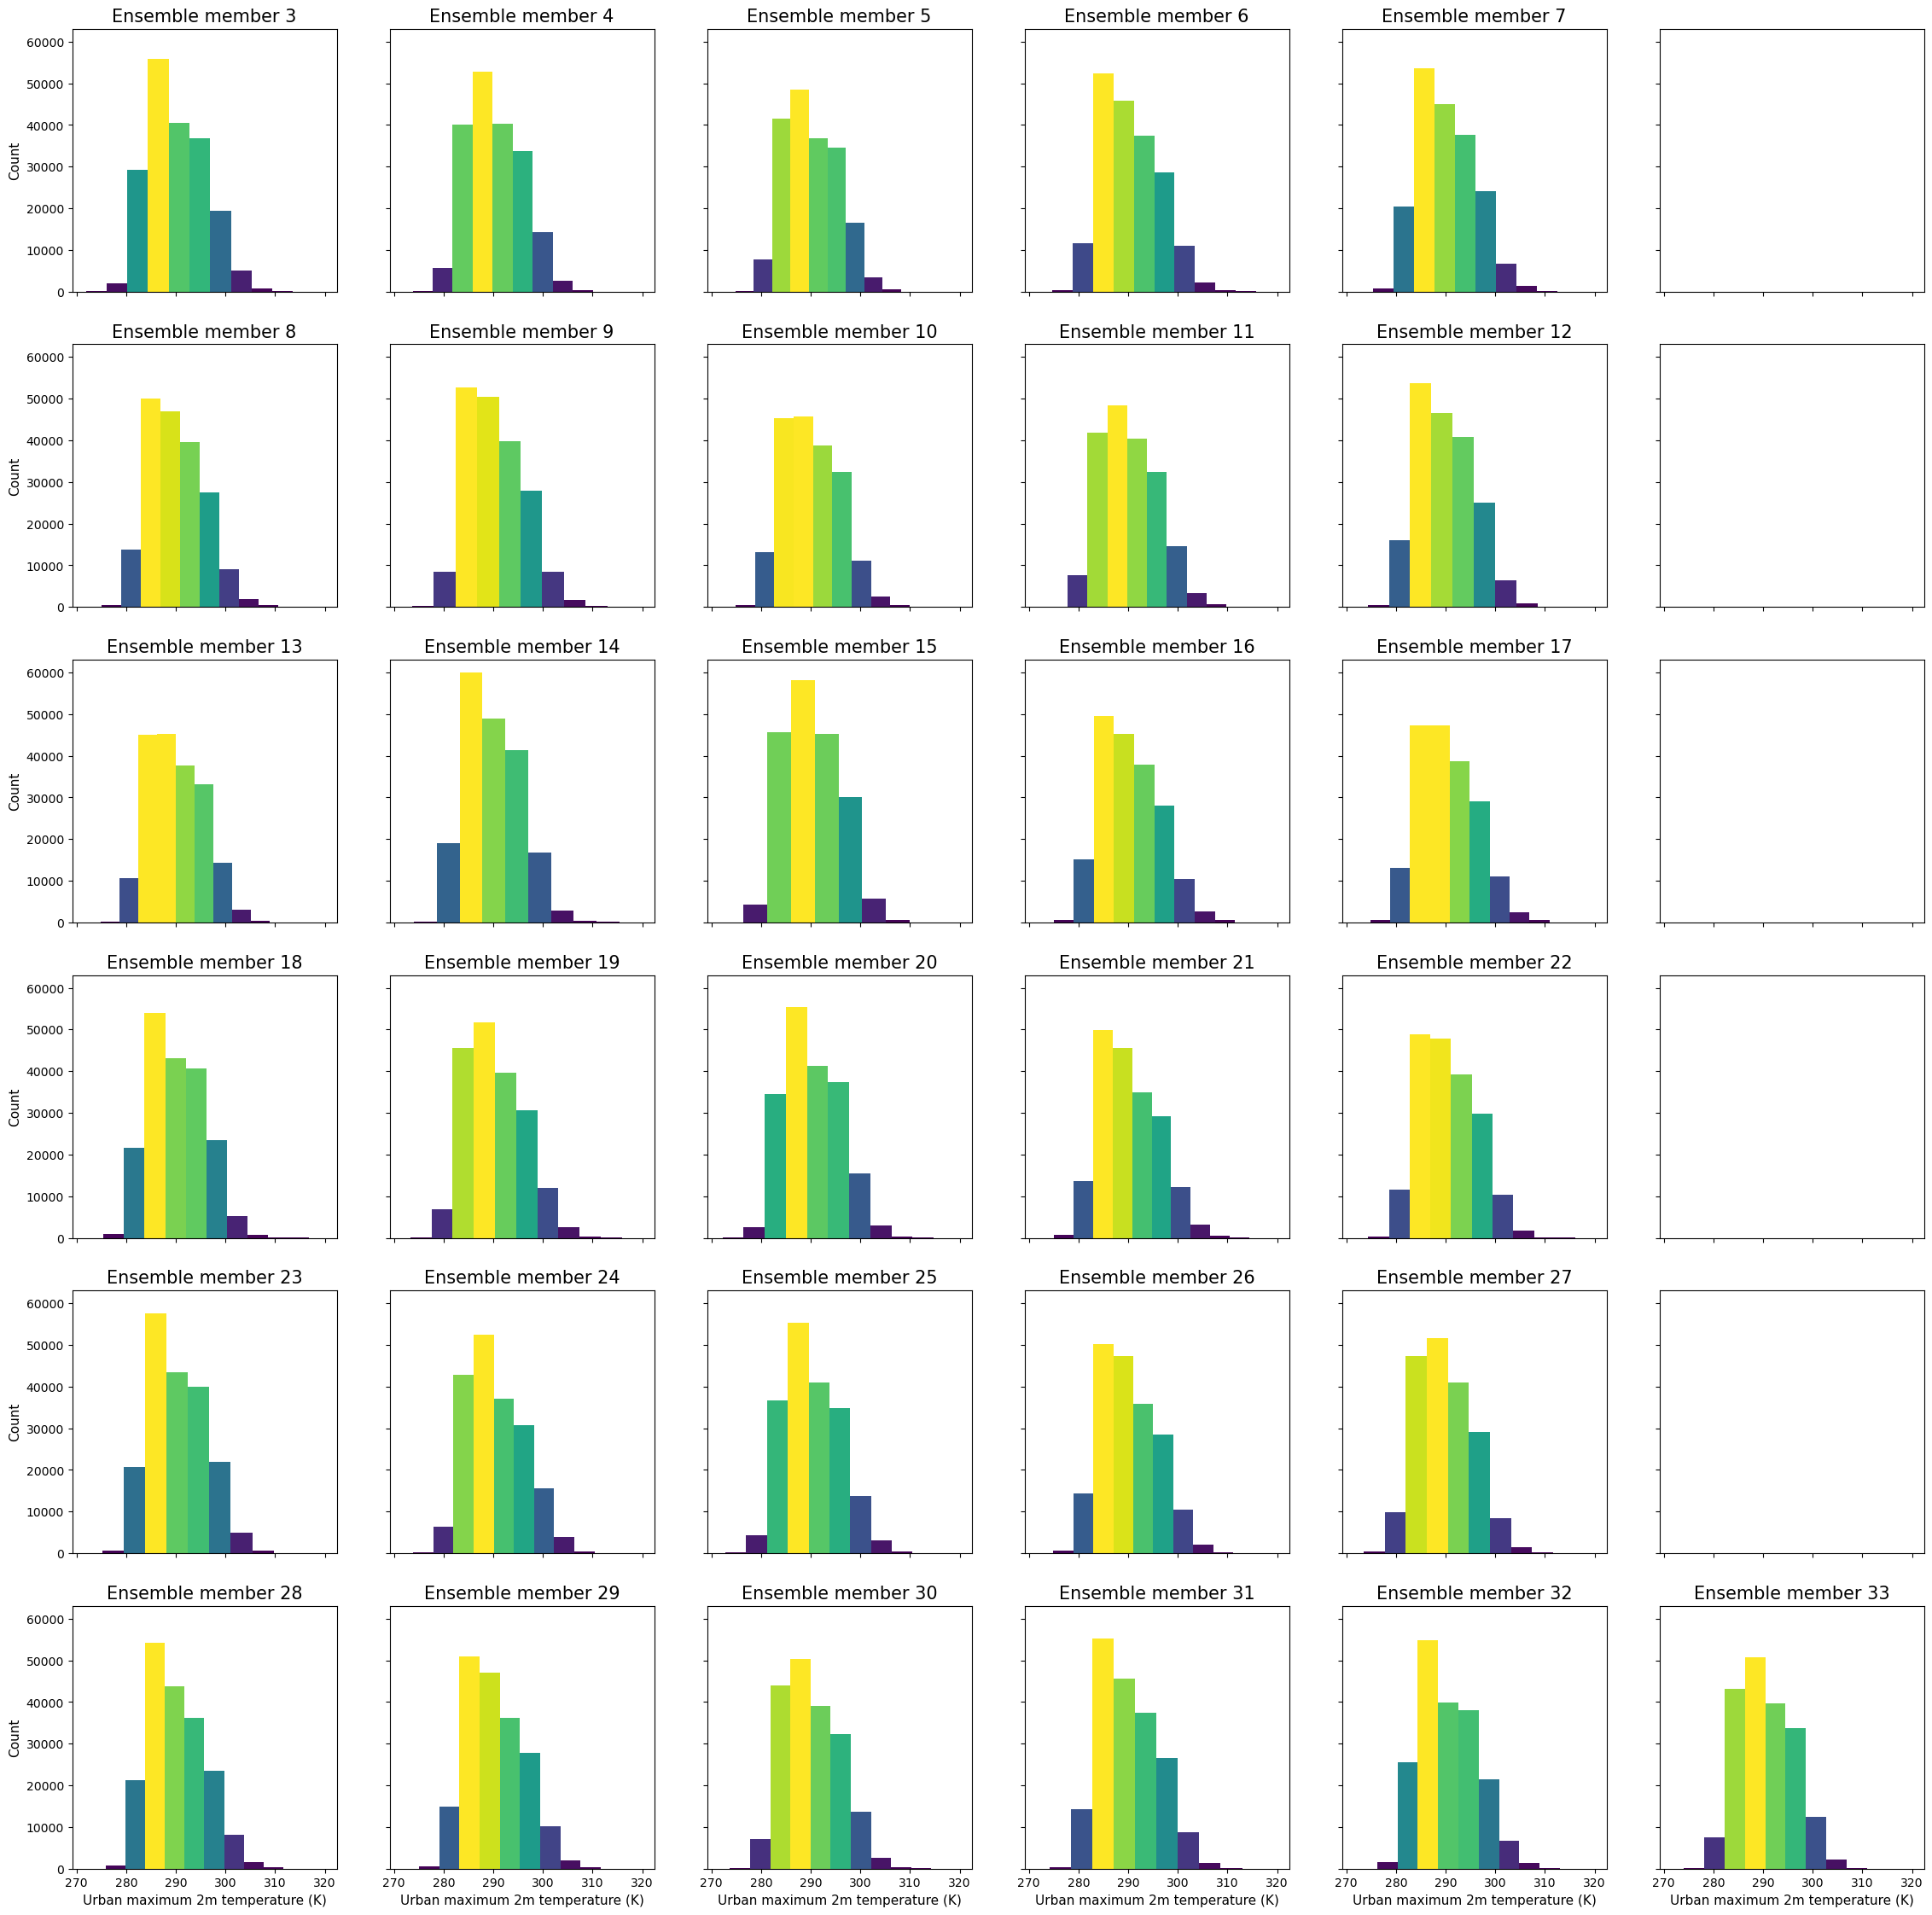

In [24]:
## Colour-coding bins by height
import matplotlib.pyplot as plt
from matplotlib import colors

fig, axs = plt.subplots(6,6, figsize=(28, 28),sharex=True,sharey=True)

##Set number of bins
n_bins = 10
##Using only the data between 2071 - 2080
##h is the df index position which iterates through each column
h = 0
## For first 5 rows of subplots (with 5 columns of plots)
for i in range(5):
    for j in range(5):
        # N is the count in each bin, bins is the lower-limit of the bin
        N, bins, patches = axs[i,j].hist(df_end_of_century_label_combined.iloc[:,h], bins=n_bins)
        # We'll color code by height, but you could use any scalar
        fracs = N / N.max()
        # we need to normalize the data to 0..1 for the full range of the colormap
        norm = colors.Normalize(fracs.min(), fracs.max())
        # Now, we'll loop through our objects and set the color of each accordingly
        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.viridis(norm(thisfrac))
            thispatch.set_facecolor(color)
        h += 1
## For last row of subplots (with 6 columns of plots)
for k in range(1):
    for l in range(6):
        N, bins, patches = axs[5,l].hist(df_end_of_century_label_combined.iloc[:,h], bins=n_bins)
        fracs = N / N.max()
        norm = colors.Normalize(fracs.min(), fracs.max())
        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.viridis(norm(thisfrac))
            thispatch.set_facecolor(color)
        h += 1

        
## Set subtitle and x- and y-axis
##first 5 rows
k=0
for i in range(5):
    for j in range(5):
        axs[i,j].set_xlabel(" ")
        axs[i,j].set_ylabel(" ")
        axs[i,j].set_title(titles[k], fontsize = 15)
        k += 1

## Last row
for i in range(1):
    for j in range(6):
        ##i+5 because we're starting from row 5 (0+5=5)
        axs[i+5,j].set_xlabel(" ")
        axs[i+5,j].set_ylabel(" ")
        axs[i+5,j].set_title(titles[k], fontsize = 15)
        k += 1

for i in range(6):
    axs[i,0].set_ylabel("Count", fontsize = 11)
    axs[5,i].set_xlabel("Urban maximum 2m temperature (K)", fontsize = 11)

# Save the full figure...
#fig.savefig('Histogram temperature distribution coloured for all ensemble members (2071-2080).png')

# Temperature time series plots

## Normal vs Extreme members

### Creating data frame of yearly-averaged temperature

In [25]:
##Timeseries plot of 'TREFMXAV_U' variable for whole simulation period (2006-2080)
##Creating xarray objects of ensemble members
ensemble5 = datasets[2]
ensemble3 = datasets[0]
ensemble14 = datasets[11]
ensemble15 = datasets[12]

##Selecting just label variable and records at all locations, and re-sampling for mean average (less messy)
df_ensemble5_label = ensemble5.TREFMXAV_U.to_dataframe().dropna()
df_ensemble3_label = ensemble3.TREFMXAV_U.to_dataframe().dropna()
df_ensemble14_label = ensemble14.TREFMXAV_U.to_dataframe().dropna()
df_ensemble15_label = ensemble15.TREFMXAV_U.to_dataframe().dropna()

## Group by year and calculate mean 
df_ensemble5_label_mean = df_ensemble5_label.groupby(df_ensemble5_label.index.get_level_values('time').year).mean()
df_ensemble3_label_mean = df_ensemble3_label.groupby(df_ensemble3_label.index.get_level_values('time').year).mean()
df_ensemble14_label_mean = df_ensemble14_label.groupby(df_ensemble14_label.index.get_level_values('time').year).mean()
df_ensemble15_label_mean = df_ensemble15_label.groupby(df_ensemble15_label.index.get_level_values('time').year).mean()

## Adding the means of the 3 locations into 1 dataframe
normal_extremes_mean = pd.concat([df_ensemble5_label_mean, df_ensemble3_label_mean, df_ensemble14_label_mean, df_ensemble15_label_mean], axis=1)

## Renaming column as ensemble member number
##List of names
column_names = ['Normal', 'Extreme cold', 'Extreme hot', 'Extreme hot & cold']

for i in range(4):
    normal_extremes_mean.columns.values[i] = column_names[i]

#print("Yearly-averaged temperature for 'normal' and 'extreme' members:")
#display(normal_extremes_mean)

### Visualising time series of 'normal' and 'extreme' members (yearly-averages)

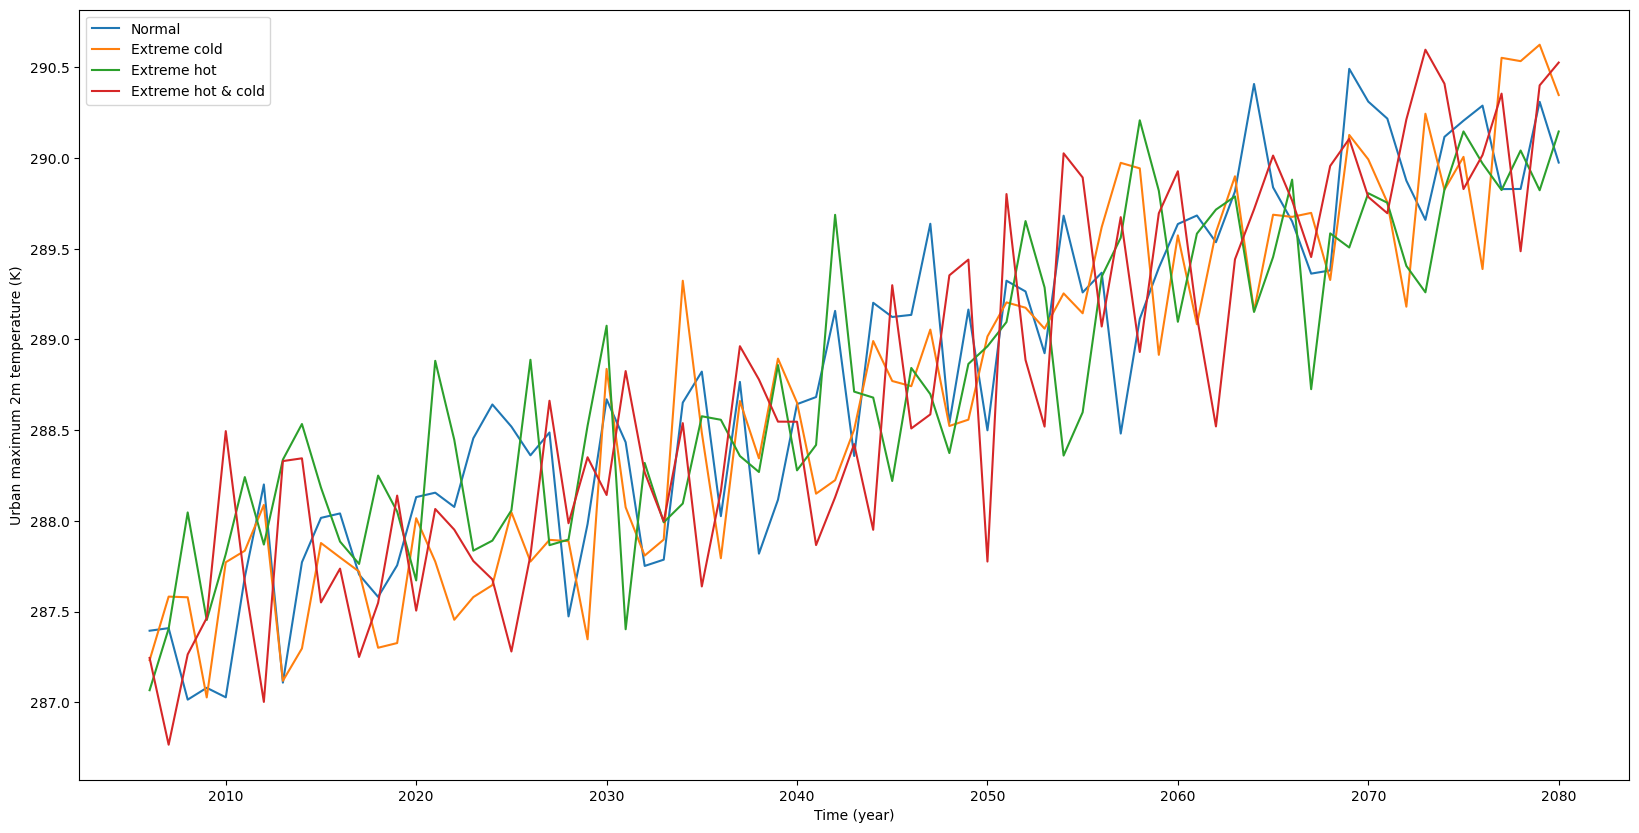

In [26]:
##Plotting time series plot
normal_extremes_ts = normal_extremes_mean.plot(figsize=(20,10))
normal_extremes_ts.set_xlabel("Time (year)")
normal_extremes_ts.set_ylabel("Urban maximum 2m temperature (K)")
plt.savefig('Normal vs 3 Extreme estimates Mean yearly temp timeseries ALL LOCATIONS (2006-2080).png')

### Quantifying biggest year-to-year jump

In [27]:
##Finding the biggest year-to-consecutive year jump in temperature
##For extreme hot & cold member 15
extreme_hot_cold = normal_extremes_mean['Extreme hot & cold']
##Take absolute values of temperature change
extreme_hot_cold = np.absolute(extreme_hot_cold)
print("Biggest jump for Extreme hot & cold member:") #21
display(np.gradient(extreme_hot_cold).max())
##For extreme hot member 3
extreme_hot = normal_extremes_mean['Extreme hot']
##Take absolute values of temperature change
extreme_hot = np.absolute(extreme_hot)
print("Biggest jump for Extreme hot member:")
display(np.gradient(extreme_hot).max())
##For extreme cold member 14
extreme_cold = normal_extremes_mean['Extreme cold']
##Take absolute values of temperature change
extreme_cold = np.absolute(extreme_cold)
print("Biggest jump for Extreme cold member:")
display(np.gradient(extreme_cold).max())
##For normal member 5
normal = normal_extremes_mean['Normal']
##Take absolute values of temperature change
normal = np.absolute(normal)
print("Biggest jump for normal member:")
display(np.gradient(normal).max())

Biggest jump for Extreme hot & cold member:


0.691391

Biggest jump for Extreme hot member:


0.7045593

Biggest jump for Extreme cold member:


0.75779724

Biggest jump for normal member:


0.5984955

## Full year, Summer and Winter annual average time series plot

### Calculating temperature change (start-of-century vs end-of-century) for Full year

In [28]:
##Group by 'Year' column and calculate mean TREFMXAV_U across each group (year)
yearly_mean_full = df_full.groupby('Year')['TREFMXAV_U'].mean()

In [29]:
##Compare first 3 decades (2006 - 2035) to last 3 decades (2051 - 2080)
first_decades = yearly_mean_full.iloc[:30]
last_decades = yearly_mean_full.iloc[-30:]

##Calculate mean gradient of first and last decade
print("Mean change in temperature (annual-average) between 2006-2035:", np.mean(np.gradient(first_decades)),"K")
print("Mean change in temperature (annual-average) between 2051-2080:", np.mean(np.gradient(last_decades)),"K")

Mean change in temperature (annual-average) between 2006-2035: 0.0326453934476433 K
Mean change in temperature (annual-average) between 2051-2080: 0.044700486858266684 K


### Splitting-up into Summer and Winter

In [30]:
##Array storing just summer June-July-August dates and only label variable in Xarray format      
summer_datasets = []

##Selecting only the TREFMXAV_U variable and seasons JJA
for i in range(31):
    ##Splitting 'time' into season and only selecting 'JJA' season
    to_add = datasets[i].sel(time=datasets[i].time.dt.season=='JJA')
    summer_datasets.append(to_add)
    
##Array storing just summer June-July-August dates and only label variable in Pandas format      
df_summer = []    
    
## Converting to pandas dataframe while dropping null values
for i in summer_datasets:
    to_add = i.to_dataframe().dropna()
    df_summer.append(to_add)
    
##Combining into one large dataset
df_summer = pd.concat(df_summer, axis=0)     ## axis=0 ensures it concatenates row-wise
#display(df_summer)

In [31]:
##Array storing just summer December-January-February dates and only label variable in Xarray format      
winter_datasets = []

##Selecting only the TREFMXAV_U variable and seasons DJF
for i in range(31):
    ##Splitting 'time' into season and only selecting 'DJF' season
    to_add = datasets[i].sel(time=datasets[i].time.dt.season=='DJF')
    winter_datasets.append(to_add)
    
##Array storing just summer December-January-February dates and only label variable in Pandas format      
df_winter = []    
    
## Converting to pandas dataframe while dropping null values
for i in winter_datasets:
    to_add = i.to_dataframe().dropna()
    df_winter.append(to_add)
    
##Combining into one large dataset
df_winter = pd.concat(df_winter, axis=0)     ## axis=0 ensures it concatenates row-wise
#display(df_winter)

In [32]:
##Only need to retain 'time' and label column
##Reset index
df_summer = df_summer.reset_index()
df_winter = df_winter.reset_index()
##Grab just time and label columns
df_summer = df_summer[['time','TREFMXAV_U']]
df_winter = df_winter[['time','TREFMXAV_U']]

##Need to convert 'time' to datetime domain, same way as before
##Save and load back in as CSV file to get rid of data domains
df_summer.to_csv('Summer dataset.csv')
df_summer = pd.read_csv('Summer dataset.csv',index_col=0)
df_winter.to_csv('Winter dataset.csv')
df_winter = pd.read_csv('Winter dataset.csv',index_col=0)

##Convert time to datetime format
df_summer['time'] = pd.to_datetime(df_summer['time'])
df_winter['time'] = pd.to_datetime(df_winter['time'])

##Checking time is datetime domain
#display(df_summer.info())
#display(df_winter.info())

### Calculating temperature change (start-of-century vs end-of-century) Summer and Winter

In [33]:
##Making data frame of annual average temperature for summer and winter
##Group by 'Year' column and calculate mean TREFMXAV_U across each group (year)
yearly_mean_summer = df_summer.groupby(df_summer['time'].dt.year)['TREFMXAV_U'].mean()
##Group by 'Year' column and calculate mean TREFMXAV_U across each group (year)
yearly_mean_winter = df_winter.groupby(df_winter['time'].dt.year)['TREFMXAV_U'].mean()

In [34]:
##Compare first 3 decades (2006 - 2035) to last 3 decades (2051 - 2080)
first_decades = yearly_mean_summer.iloc[:30]
last_decades = yearly_mean_summer.iloc[-30:]

##Calculate mean gradient of first and last decade
print("Mean change in temperature (summer-average) between 2006-2035:", np.mean(np.gradient(first_decades)),"K")
print("Mean change in temperature (summer-average) between 2051-2080:", np.mean(np.gradient(last_decades)),"K")

Mean change in temperature (summer-average) between 2006-2035: 0.043846986744568994 K
Mean change in temperature (summer-average) between 2051-2080: 0.07456483772746196 K


In [35]:
##Compare first 3 decades (2006 - 2035) to last 3 decades (2051 - 2080)
first_decades = yearly_mean_winter.iloc[:30]
last_decades = yearly_mean_winter.iloc[-30:]

##Calculate mean gradient of first and last decade
print("Mean change in temperature (winter-average) between 2006-2035:", np.mean(np.gradient(first_decades)),"K")
print("Mean change in temperature (winter-average) between 2051-2080:", np.mean(np.gradient(last_decades)),"K")

Mean change in temperature (winter-average) between 2006-2035: 0.02700068426243547 K
Mean change in temperature (winter-average) between 2051-2080: 0.023655600383697597 K


### Visualise Annual-, Summer- and Winter-mean temperatures for full simulation period 

In [36]:
##Make data frame combining yearly-averages for full, summer and winter periods
yearly_mean = pd.concat([yearly_mean_full,yearly_mean_summer,yearly_mean_winter],axis=1)

## Renaming column as season
yearly_mean.columns.values[0] = 'Yearly-average'
yearly_mean.columns.values[1] = 'JJA'
yearly_mean.columns.values[2] = 'DJF'

#display(yearly_mean)

Text(0, 0.5, 'Urban maximum 2m temperature (K)')

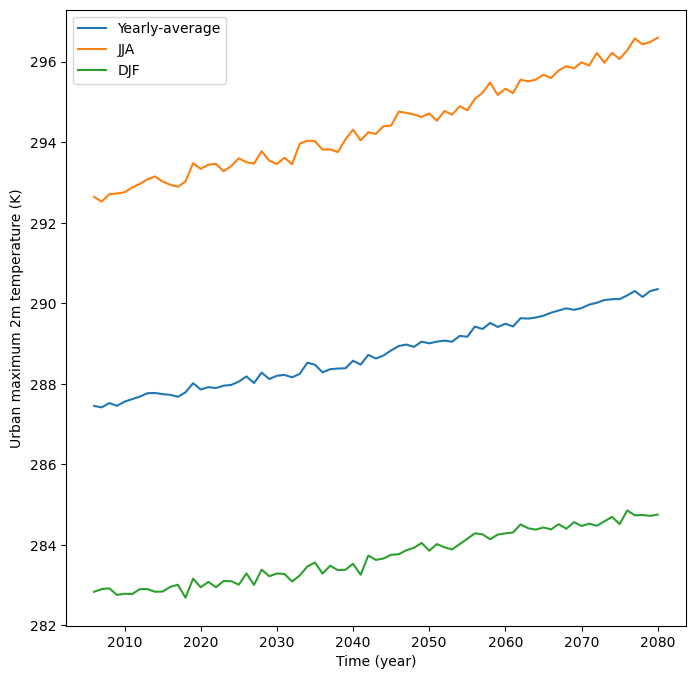

In [37]:
##Make time series plot (with 3 plots: Annual, Summer, Winter)
yearly_mean_ts = yearly_mean.plot(figsize=(8,8))
yearly_mean_ts.set_xlabel("Time (year)")
yearly_mean_ts.set_ylabel("Urban maximum 2m temperature (K)")
#plt.savefig('Mean yearly temp timeseries ALL LOCATIONS (2006-2080) (1).png')

## Major UK cities time series plot

In [38]:
london_yearly_mean = major_city_plot(51.507431, -0.127643)
manchester_yearly_mean = major_city_plot(53.480771, -2.242627)
birmingham_yearly_mean = major_city_plot(52.486101, -1.890431)
cardiff_yearly_mean = major_city_plot(51.483727, -3.168101)
edinburgh_yearly_mean = major_city_plot(55.953433, -3.188716)
belfast_yearly_mean = major_city_plot(54.597280, -5.930382)

In [39]:
##Merging all UK major cities into single data frame
##Adding the means of the 3 locations into 1 dataframe
major_cities_yearly_mean = pd.concat([london_yearly_mean, manchester_yearly_mean, birmingham_yearly_mean, cardiff_yearly_mean, edinburgh_yearly_mean, belfast_yearly_mean], axis=1)
## Rename columns with location names
major_cities_yearly_mean = major_cities_yearly_mean.rename(columns={0:'London', 1:'Manchester', 2:'Birmingham', 3:'Cardiff', 4:'Edinburgh', 5:'Belfast'})
#display(major_cities_yearly_mean)

Text(0, 0.5, 'Urban maximum 2m temperature (K)')

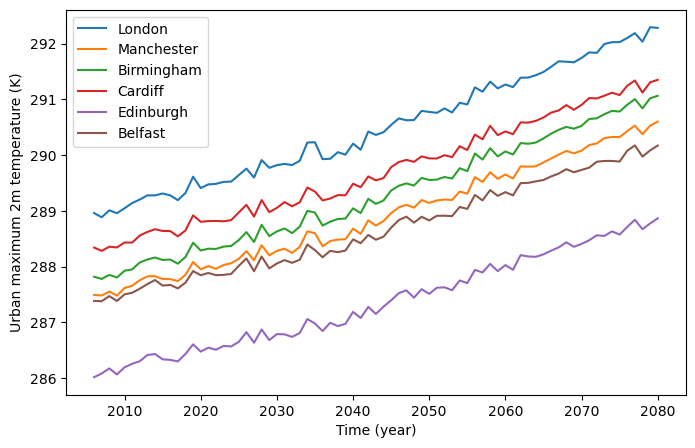

In [40]:
##Make time-series plot of all 6 major cities
major_cities_yearly_mean_ts = major_cities_yearly_mean.plot(figsize=(8,5))
major_cities_yearly_mean_ts.set_xlabel("Time (year)")
major_cities_yearly_mean_ts.set_ylabel("Urban maximum 2m temperature (K)")
#plt.savefig('6 Major UK cities All ensemble members Mean yearly temp timeseries (2006-2080).png')

## Feature variable time series

From here!!!!

In [41]:
##Makes list of features to plot
features = df_full.columns.values.tolist()
##Select feature columns from FLNS onwards
features = features[4:]

display(features)

['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT']

In [42]:
all_locations_mean = df_full.groupby('Year')[features].mean()
display(all_locations_mean)

FLNS        FSNS         PRECT          PRSN      QBOT      TREFHT  \
Year                                                                            
2006  47.509743  102.558297  3.539351e-08  5.188258e-10  0.006253  284.061126   
2007  47.556005  102.479197  3.460229e-08  4.450508e-10  0.006218  284.016203   
2008  47.531315  103.192432  3.505947e-08  4.674342e-10  0.006288  284.131794   
2009  47.579312  103.083840  3.628436e-08  5.246947e-10  0.006259  284.062349   
2010  47.510116  103.199015  3.517937e-08  5.090850e-10  0.006300  284.148786   
...         ...         ...           ...           ...       ...         ...   
2076  47.859744  112.773340  3.442289e-08  5.681749e-11  0.007257  286.637948   
2077  47.295821  112.344053  3.556875e-08  8.612215e-11  0.007375  286.766918   
2078  47.435166  111.689984  3.674067e-08  7.153305e-11  0.007292  286.641938   
2079  47.611393  112.418546  3.667500e-08  7.206033e-11  0.007321  286.743582   
2080  47.901864  113.095697  3.483306e-08  6.451100e-11  0.007334  286.767632   

          UBOT      VBOT  
Year                      
2006  1.655630  1.706771  
2007  1.578907  1.693330  
2008  1.384445  1.765948  
2009  1.589379  1.659889  
2010  1.597994  1.757923  
...        ...       ...  
2076  1.824035  1.493984  
2077  1.673435  1.492300  
2078  1.862847  1.597861  
2079  1.980643  1.741673  
2080  1.863473  1.682948  

[75 rows x 8 columns]

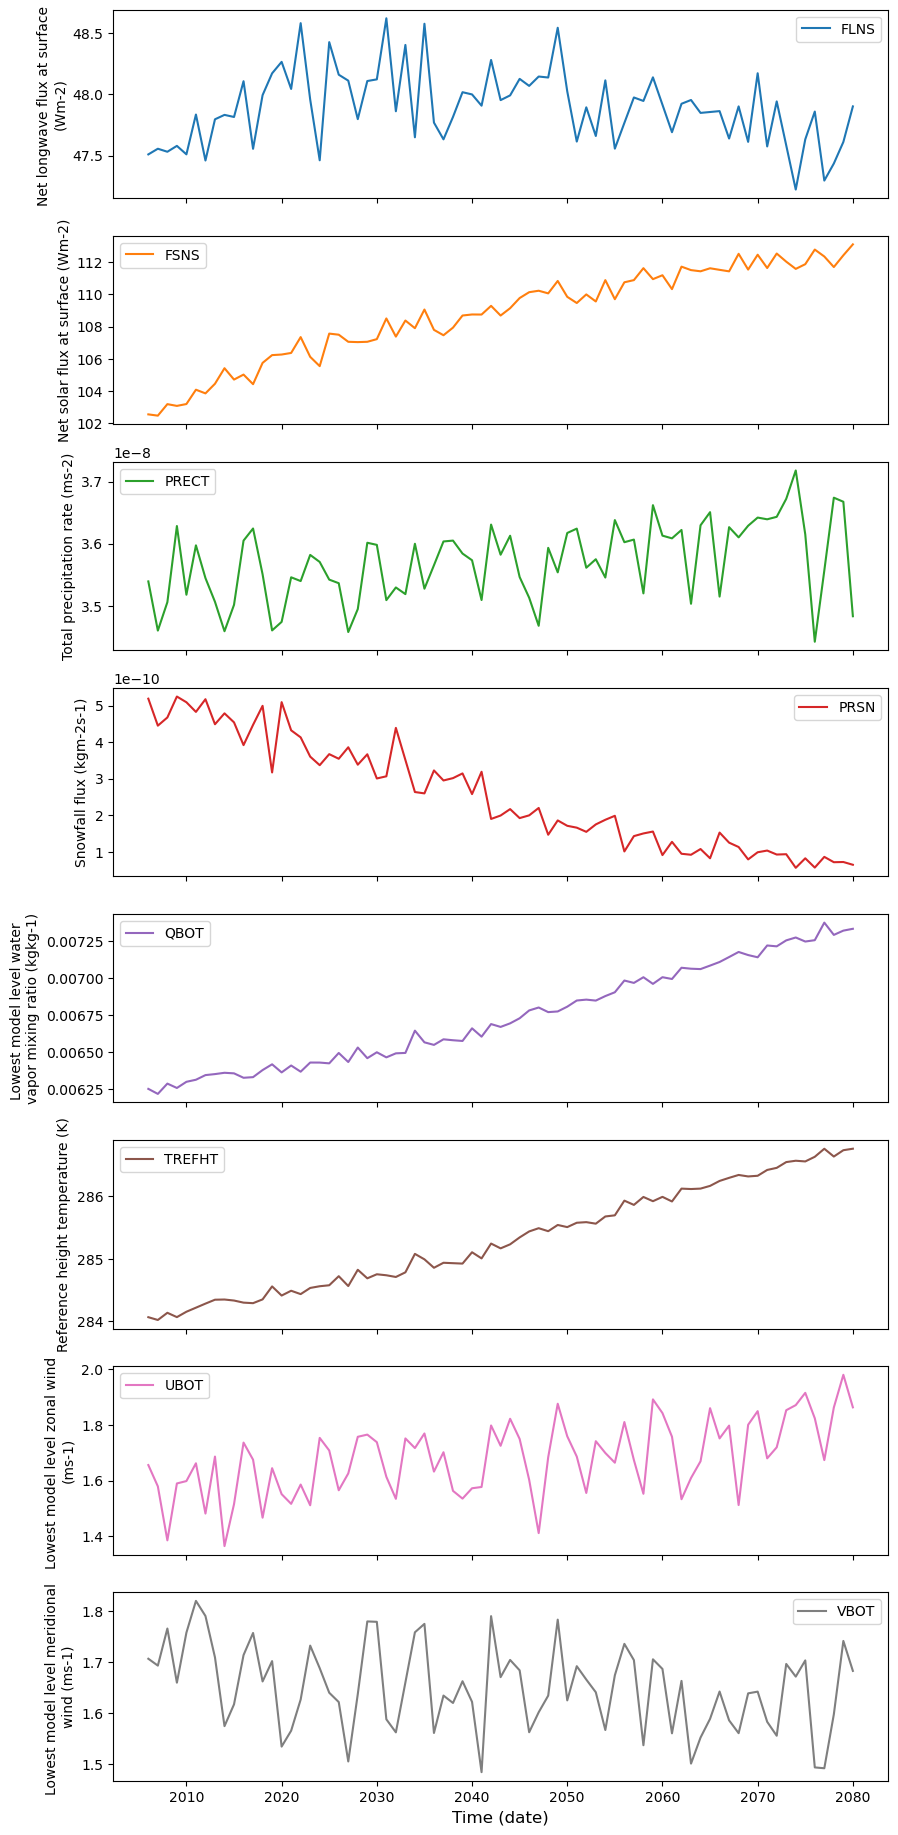

In [43]:
axs = all_locations_mean.plot(subplots=True, figsize=(10, 23))

##Set x-axis (only bottom plot since all share same x-axis)
axs[7].set_xlabel("Time (date)", fontsize = 12)
##Set y-axis individually
axs[0].set_ylabel("Net longwave flux at surface \n(Wm-2)")
axs[1].set_ylabel("Net solar flux at surface (Wm-2)")
axs[2].set_ylabel("Total precipitation rate (ms-2)")
axs[3].set_ylabel("Snowfall flux (kgm-2s-1)")
axs[4].set_ylabel("Lowest model level water \nvapor mixing ratio (kgkg-1)")
axs[5].set_ylabel("Reference height temperature (K)")
axs[6].set_ylabel("Lowest model level zonal wind \n(ms-1)")
axs[7].set_ylabel("Lowest model level meridional \nwind (ms-1)")

#plt.subplots_adjust(bottom=0.001,
#                    top=1.0,
#                    wspace=0.4,
#                    hspace=0.4
#                   )

# Save the full figure...
plt.savefig('ALL LOCATIONS ALL MEMBERS timeseries plot of features (2006-2080) (1).png')
#plt.show()

# Zonal plot

#### <font color=green>Just "end of century" (2071-2080)</font>

In [44]:
##Plot made in Xarray
##Using just "end of century" (2071-2080) data
##plot of 'TREFMXAV_U' variable for whole simulation period (2006-2080)
ensemble5_label_end_of_century = datasets_label_end_of_century[2]
display(ensemble5_label_end_of_century)

<xarray.DataArray 'TREFMXAV_U' (time: 3650, lat: 11, lon: 8)>
array([[[      nan,       nan,       nan, ..., 288.55945, 288.87592,
         288.56567],
        [      nan,       nan, 288.3105 , ...,       nan,       nan,
         288.26288],
        [      nan,       nan,       nan, ..., 288.16904, 288.07114,
         288.10086],
        ...,
        [      nan,       nan,       nan, ..., 281.16125,       nan,
               nan],
        [      nan, 281.20532,       nan, ..., 281.83136,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 286.25143, 286.16745,
         286.07617],
        [      nan,       nan, 285.4374 , ...,       nan,       nan,
         285.67722],
        [      nan,       nan,       nan, ..., 283.1625 , 283.99585,
         284.40103],
...
        [      nan,       nan,       nan, ..., 288.41696,       nan,
               nan],
        [      nan, 285.55682,       nan, ..., 287.94608,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 286.09323, 286.19482,
         285.94916],
        [      nan,       nan, 287.00177, ...,       nan,       nan,
         286.50668],
        [      nan,       nan,       nan, ..., 286.51358, 287.03275,
         287.23605],
        ...,
        [      nan,       nan,       nan, ..., 286.6059 ,       nan,
               nan],
        [      nan, 285.33682,       nan, ..., 285.87598,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 49.48 50.42 51.36 52.3 ... 56.07 57.02 57.96 58.9
  * lon      (lon) float32 -7.5 -6.25 -5.0 -3.75 -2.5 -1.25 0.0 1.25
  * time     (time) object 2071-01-01 00:00:00 ... 2080-12-31 00:00:00
Attributes:
    long_name:     Urban daily maximum of average 2-m temperature
    units:         K
    cell_methods:  time: mean

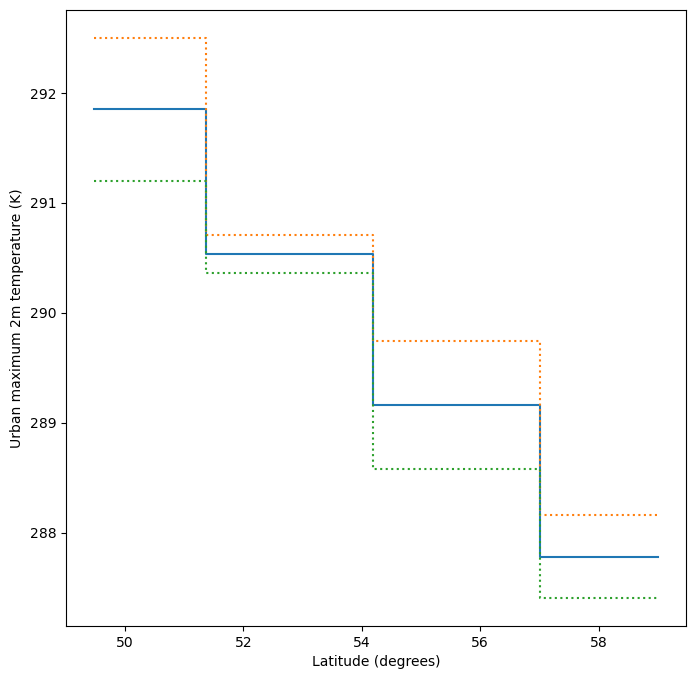

In [45]:
## Define Xarray of Ensemble member 5 for the "end of century" period
ensemble5_label_end_of_century = datasets_label_end_of_century[2]

##One focus variable latitude - Group by 5 bins of latitude
##Take mean of other variables time and longitude
temp_grp = ensemble5_label_end_of_century.mean(["time", "lon"]).groupby_bins("lat", [49.47644, 51.361256, 54.18848, 57.015705,59])   ## This goes northward from 49 to 57

fig, ax = plt.subplots(figsize=(8,8))

## Calculate mean and standard deviation
temp_mean = temp_grp.mean()
temp_std = temp_grp.std()

## Plot mean and standard deviation (positive & negative)
temp_mean.plot.step()
(temp_mean + temp_std).plot.step(ls=":")
(temp_mean - temp_std).plot.step(ls=":")

## Axis labels and Title
plt.xlabel("Latitude (degrees)")
plt.ylabel("Urban maximum 2m temperature (K)")

plt.savefig('Ensemble 5 latitude zonal mean temperature (2071-2080).png')

# Seasonal Plots

Finding those long-term/consistently warm and cold projections.

In [8]:
##(Using data frame of end-of-century period of all ensemble members)
##Calculate the mean temperature between 2071-2080 and order in ascending order
df_end_of_century_label_combined.mean().sort_values(ascending=True)

27    289.719116
14    289.820129
12    289.874573
8     289.945190
13    290.017883
30    290.020386
5     290.031372
3     290.046661
10    290.049194
18    290.053558
7     290.086273
11    290.096680
26    290.115356
28    290.116852
31    290.138153
25    290.138824
15    290.153625
20    290.165131
21    290.198853
19    290.203491
4     290.224823
9     290.261444
17    290.274597
23    290.281952
29    290.343079
24    290.346313
16    290.401306
33    290.426910
22    290.435394
6     290.437927
32    290.469147
dtype: float32

Top member 27 is long-term/'consistently cold' member and bottom member 32 is for long-term/'consistently hot' member

## Map visualisations

### Summer and Winter of 2080

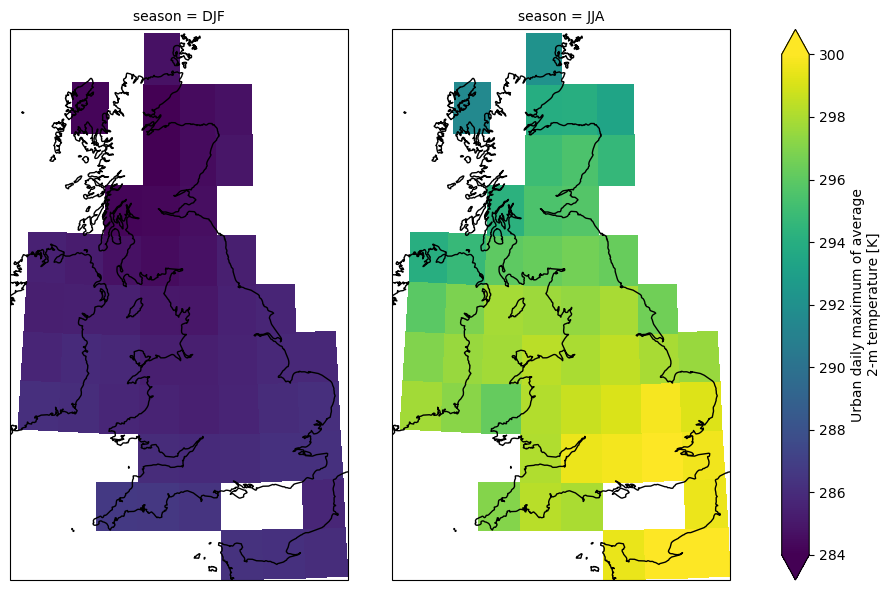

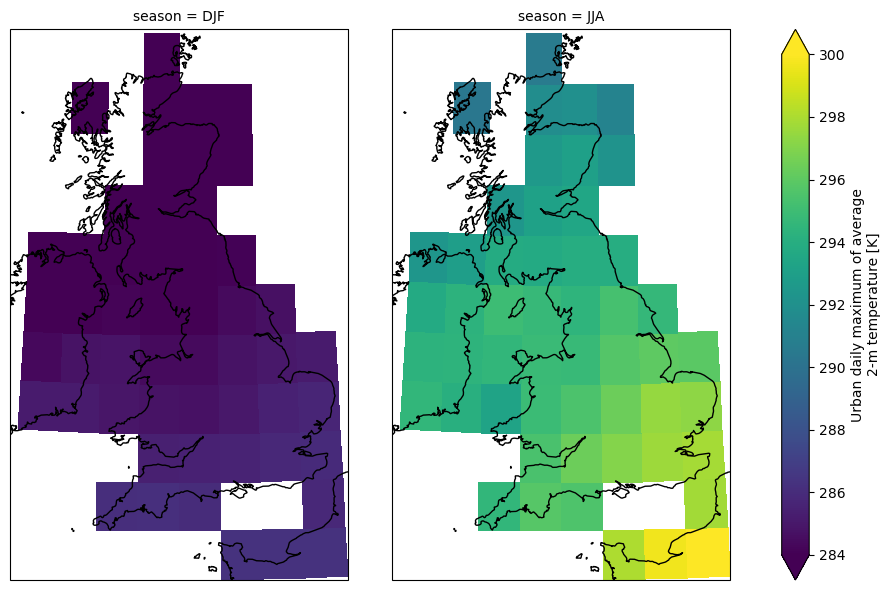

In [46]:
##Grabbing ensemble 32 xarray Dataset (could be hot)
ensemble32 = datasets[29]
##Ensemble member 32
plot_year_season(ensemble32.sel(time='2080'))
##Grabbing ensemble 27 xarray Dataset (could be cold)
ensemble27 = datasets[24]
##Ensemble member 27
plot_year_season(ensemble27.sel(time='2080'))

### First and last day

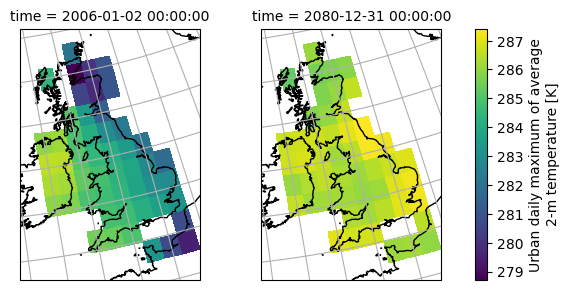

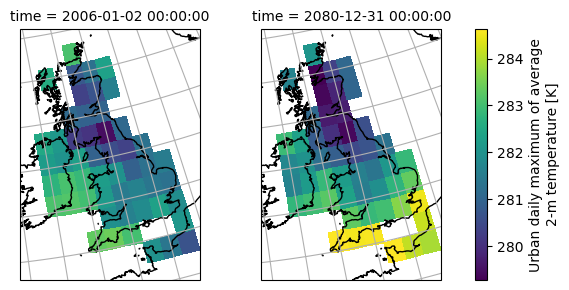

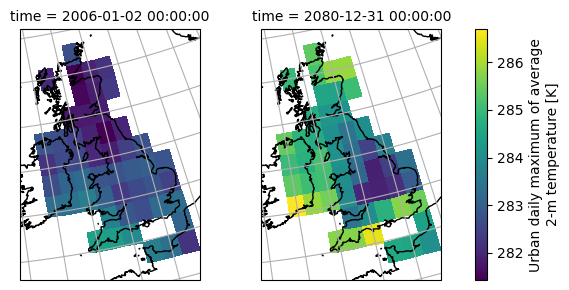

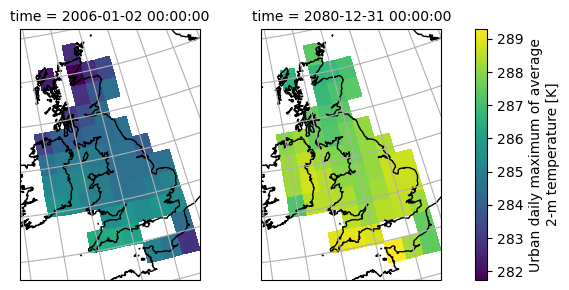

In [47]:
p = ensemble5.TREFMXAV_U.isel(time=[0,-1]).plot(
    transform=ccrs.PlateCarree(),
    col="time",
    subplot_kws={"projection": ccrs.Orthographic(-20, 45)},
)

for ax in p.axs.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.draw()

p = ensemble15.TREFMXAV_U.isel(time=[0,-1]).plot(
    transform=ccrs.PlateCarree(),
    col="time",
    subplot_kws={"projection": ccrs.Orthographic(-20, 45)},
)

for ax in p.axs.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.draw()

p = ensemble3.TREFMXAV_U.isel(time=[0,-1]).plot(
    transform=ccrs.PlateCarree(),
    col="time",
    subplot_kws={"projection": ccrs.Orthographic(-20, 45)},
)

for ax in p.axs.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.draw()

p = ensemble14.TREFMXAV_U.isel(time=[0,-1]).plot(
    transform=ccrs.PlateCarree(),
    col="time",
    subplot_kws={"projection": ccrs.Orthographic(-20, 45)},
)

for ax in p.axs.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.draw()

## Annual time series plot

In [48]:
##From Xarray, select representative ensemble member 5 at London location, just label variable and the first 3 years
##And convert to pandas data frame
seasonal1 = ensemble5.TREFMXAV_U.sel(lat=51.361256, lon=0.0, time=slice(None,"2008-12-31")).to_dataframe().dropna() ## this is the lat and lon nearest to London's
##Drop 'lat' & 'lon'
seasonal1 = seasonal1.drop(columns=['lat','lon'])
##Same process to convert 'time' to datetime format
seasonal1.to_csv('Annual Seasonality 1.csv')
seasonal1 = pd.read_csv('Annual Seasonality 1.csv')
seasonal1['time'] = pd.to_datetime(seasonal1['time'])
##Re-set 'time' as index
seasonal1 = seasonal1.set_index('time')
#display(seasonal1.info())

In [49]:
##From Xarray, select representative ensemble member 5 at London location,
##just label variable and the first 2080 year
seasonal2 = ensemble5.TREFMXAV_U.sel(lat=51.361256, lon=0.0, time=slice("2078-01-02","2080-12-31")).to_dataframe().dropna()
##Drop 'lat' & 'lon'
seasonal2 = seasonal2.drop(columns=['lat','lon'])
##Same process to convert 'time' to datetime format
seasonal2.to_csv('Annual Seasonality 2.csv')
seasonal2 = pd.read_csv('Annual Seasonality 2.csv')
seasonal2['time'] = pd.to_datetime(seasonal2['time'])
##Re-set 'time' as index
seasonal2 = seasonal2.set_index('time')
#display(seasonal2.info())

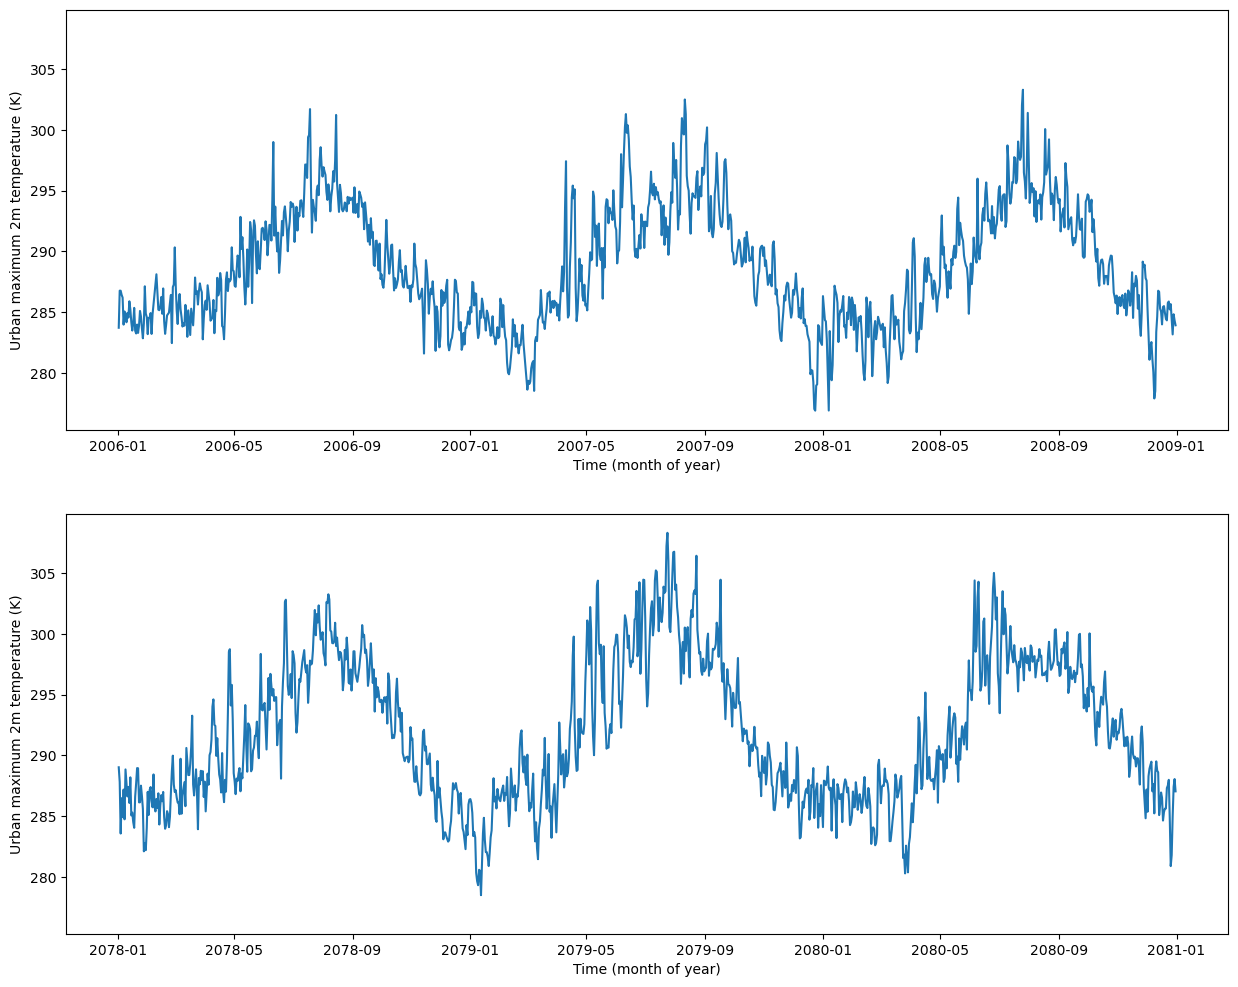

In [50]:
##Plot together
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,12), sharey=True)

ax1.plot(seasonal1)
ax1.set_ylabel("Urban maximum 2m temperature (K)")
ax1.set_xlabel("Time (month of year)")
ax2.plot(seasonal2)
ax2.set_ylabel("Urban maximum 2m temperature (K)")
ax2.set_xlabel("Time (month of year)")

plt.savefig('Ensemble 5 annual seasonal temp timeseries London (2006 & 2080).png', bbox_inches = 'tight')
#plt.show()

# Correlation Analysis

## All 31 members

In [51]:
##Create copy for plotting
df_full_copy = df_full.copy()
##Reset index because 'lat' and 'lon' used as predictor variables
df_full_copy = df_full_copy.reset_index()
##Dropping 'Ensemble_num' and and 'time' re-ordering so that label variable first column
df_full_copy = df_full_copy[['TREFMXAV_U', 'lat', 'lon','Day_of_year',
       'Year', 'FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT',
       'VBOT']]

##Correlation matrix of all members and locations
corr1 = df_full_copy.corr(method='spearman')
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr1[mask] = np.nan

C:\Users\laure\AppData\Local\Temp\ipykernel_26368\1960627235.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+var_names, rotation='vertical')
C:\Users\laure\AppData\Local\Temp\ipykernel_26368\1960627235.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+var_names)


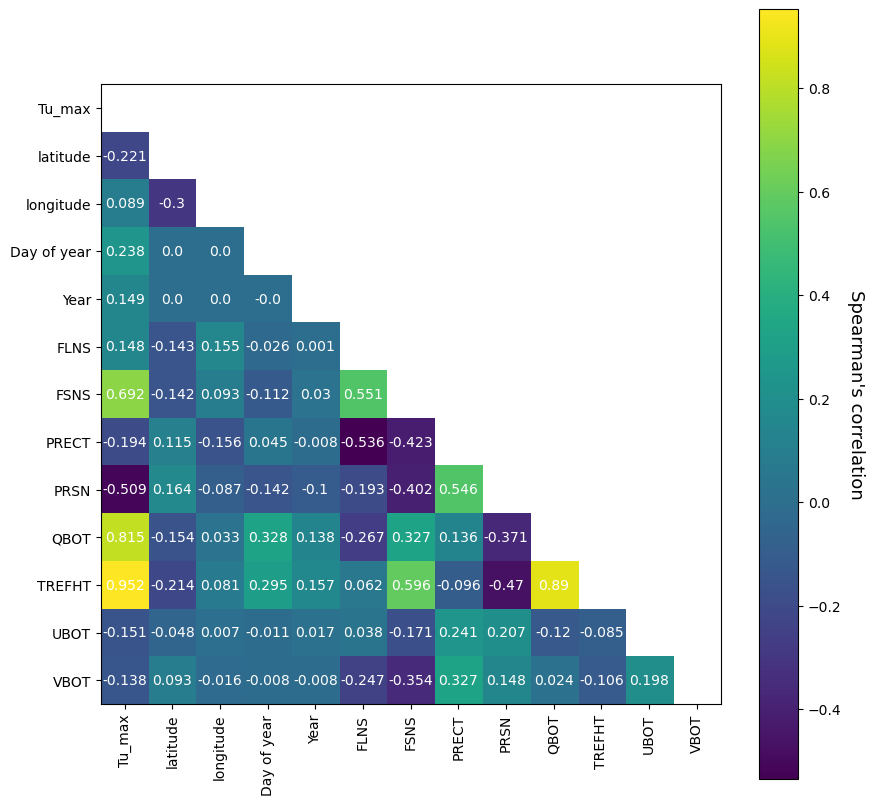

In [52]:
##List of column names
var_names = ['Tu_max', 'latitude', 'longitude','Day of year',
       'Year', 'FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT',
       'VBOT']

##Formatting correlation matrix map
figure = plt.figure(figsize=(10, 10))
axes = figure.add_subplot(111)
 
# using the matshow() function
caxes = axes.matshow(corr1, interpolation ='nearest')
#caxes = axes.matshow(corr1, interpolation ='nearest', cmap='cividis')   ## can change colour scale
cbar = figure.colorbar(caxes)
# Add the color bar
cbar.ax.set_ylabel("Spearman's correlation", rotation = -90, va = "bottom", fontsize=13)

# Add the values to each cell
for i in range(13):
    for j in range(13):
        text = axes.text(j, i, round(corr1.iloc[i, j], 3),    ## the final number is the d.p. round-up
                       ha = "center", va = "center", color = "w", fontsize = 10)

##Put x-axis along bottom of graph
axes.xaxis.tick_bottom()  ##to have x-axis along the top, # out this line
##Set x-axis ticks at every column/row        
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
axes.xaxis.set_major_locator(loc)
axes.yaxis.set_major_locator(loc)
##Label ticks with column names (rather than default numbers)
axes.set_xticklabels(['']+var_names, rotation='vertical')
axes.set_yticklabels(['']+var_names)


#plt.title('Correlation Matrix', fontsize=16)
plt.savefig('All members (mean) Correlation matrix map (2006-2080) HALF.png')
#plt.show()

## Mean members vs Extreme hot & cold (15)

In [53]:
##Grabbing ensemble member 15 data
ensemble15 = df_full.loc[df_full['Ensemble_num'] == 15]
##Re-set index
ensemble15 = ensemble15.reset_index()
##Dropping 'Ensemble_num' and 'time' and re-ordering so that label variable first column
ensemble15 = ensemble15[['TREFMXAV_U', 'lat', 'lon','Day_of_year', 'Year', 'FLNS', 
                         'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT']]
##Calculate correlation matrix
corr2 = ensemble15.corr(method='spearman')

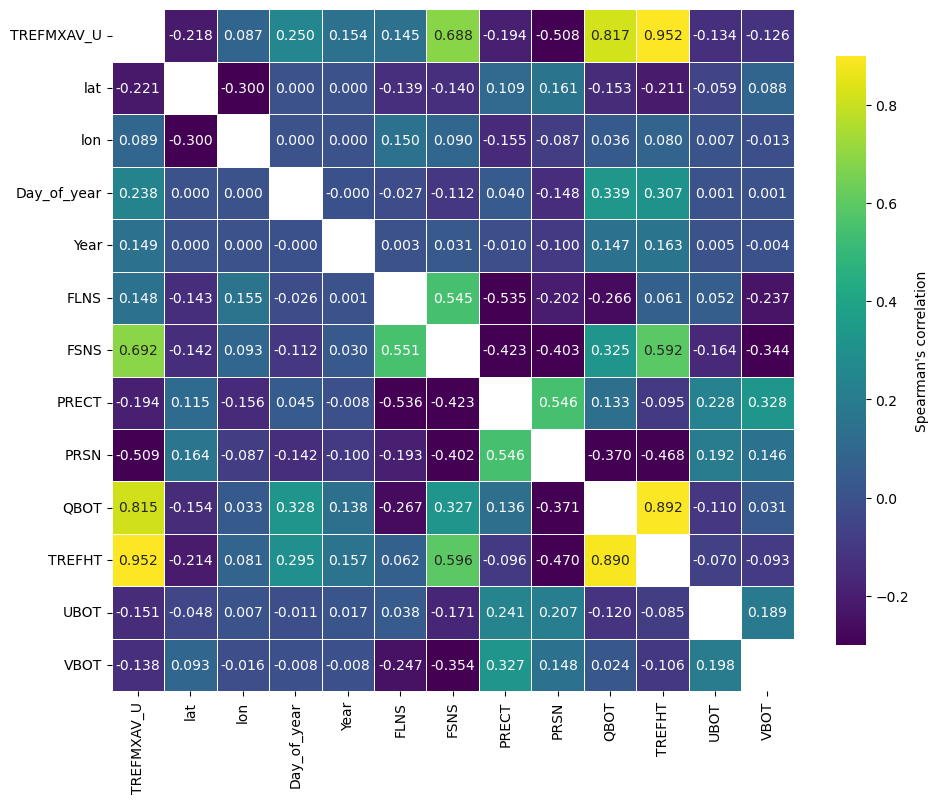

In [54]:
##Merging two halves of different correlation matrices
##Making masks for upper and lower half
mask1 = np.triu(np.ones_like(corr1, dtype=bool))
mask2 = np.tril(np.ones_like(corr2, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr1, mask=mask1, annot=True, fmt=".3f",
            cmap='viridis', 
            vmax=.9, vmin=-.3,
            square=True, linewidths=.5, 
            cbar=False,
            ax=ax)
sns.heatmap(corr2, mask=mask2, annot=True, fmt=".3f",
            cmap='viridis', 
            vmax=.9, vmin=-.3,
            square=True, linewidths=.5, 
            cbar=True, ##only need one colour bar
            cbar_kws={"shrink": .85, 
                     #"pad":-.01, 
                     "label":"Spearman's correlation"}, ax=ax)
#plt.title('Correlation Matrices for all members (bottom-left) and extreme hot & cold member (top-right)', fontsize=16)
plt.savefig('All members (mean) (bottom) vs member 15 (top) Correlation matrix map (2006-2080).png', bbox_inches = 'tight')

## Extreme cold (3) vs Extreme hot (14)

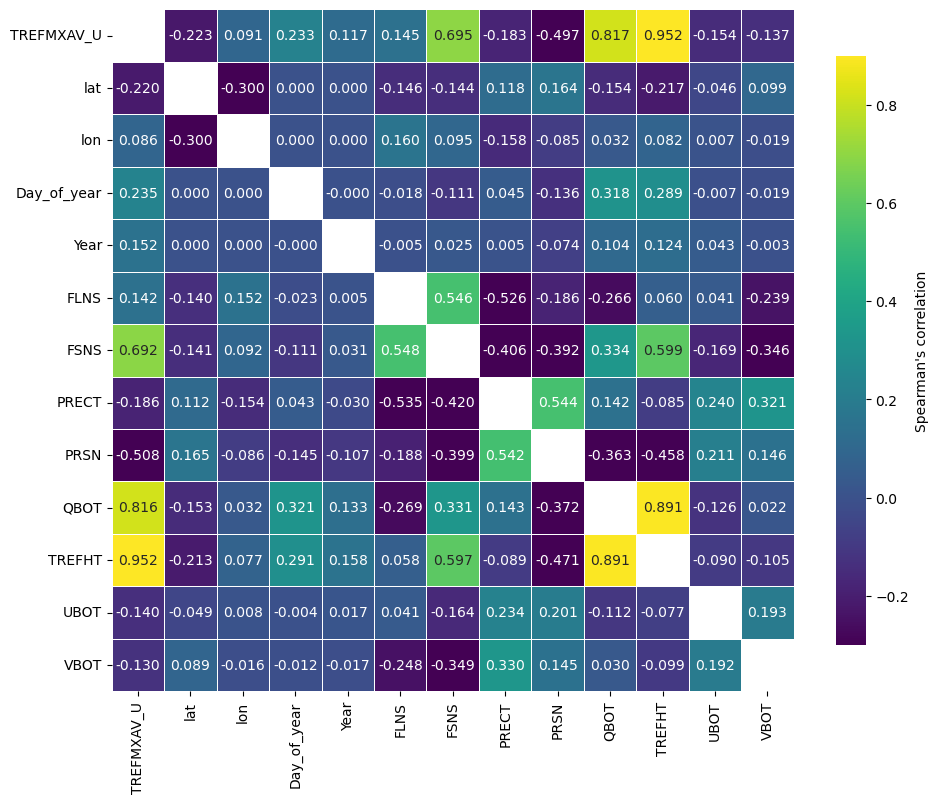

In [55]:
merge_corr(3, 14)
#plt.title('Correlation Matrices for extreme cold member (bottom-left) and extreme hot member (top-right)', fontsize=16)
plt.savefig('Member 3 (bottom) vs member 14 (top) Correlation matrix map (2006-2080).png', bbox_inches = 'tight')

## Consistent hot (32) vs consistent cold (27)

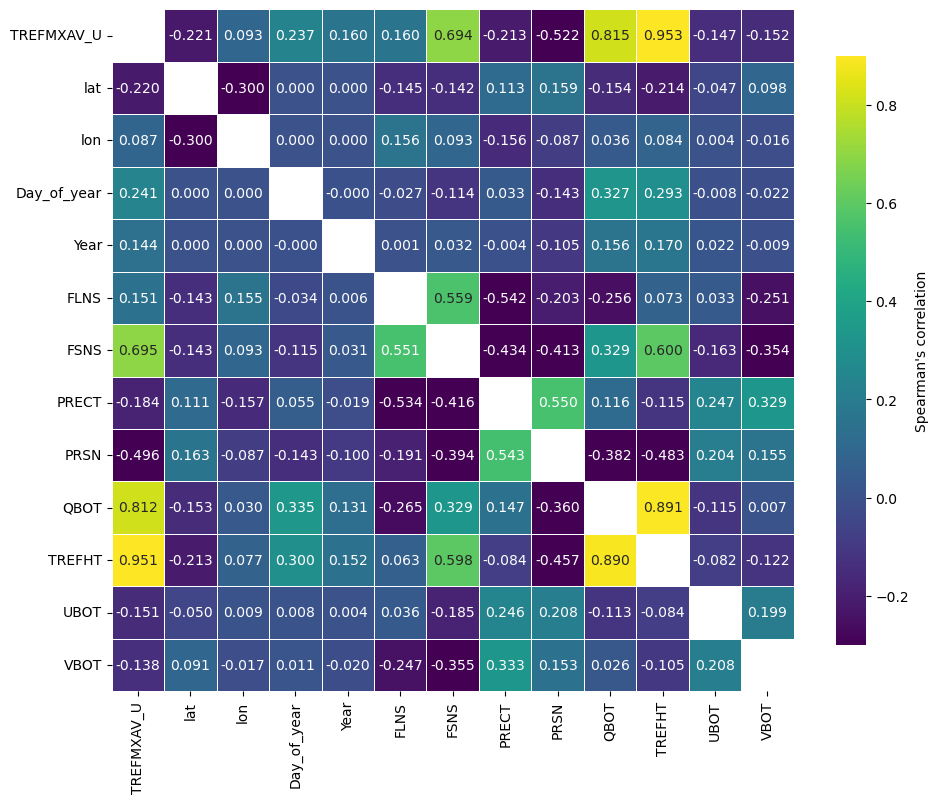

In [56]:
merge_corr(27, 32)
#plt.title('Correlation Matrices for consistently cold member (bottom-left) and consistently hot member (top-right)', fontsize=16)
plt.savefig('Member 27 (bottom) vs member 32 (top) Correlation matrix map (2006-2080).png', bbox_inches = 'tight')

# Correlation between label and temporal features

## Just member 5

### Autocorrelation plots

In [57]:
##Isolate single time series
##From Xarray, select representative ensemble member 5 at London location, just label variable
##And convert to pandas data frame
autocorr1 = ensemble5.TREFMXAV_U.sel(lat=51.361256, lon=0.0).to_dataframe().dropna() ## this is the lat and lon nearest to London's
##Drop 'lat' & 'lon'
autocorr1 = autocorr1.drop(columns=['lat','lon'])
##Same process to convert 'time' to datetime format
autocorr1.to_csv('Autocorrelation 1.csv')
autocorr1 = pd.read_csv('Autocorrelation 1.csv')
autocorr1['time'] = pd.to_datetime(autocorr1['time'])
##Re-set 'time' as index
autocorr1 = autocorr1.set_index('time')
#display(autocorr1.info())

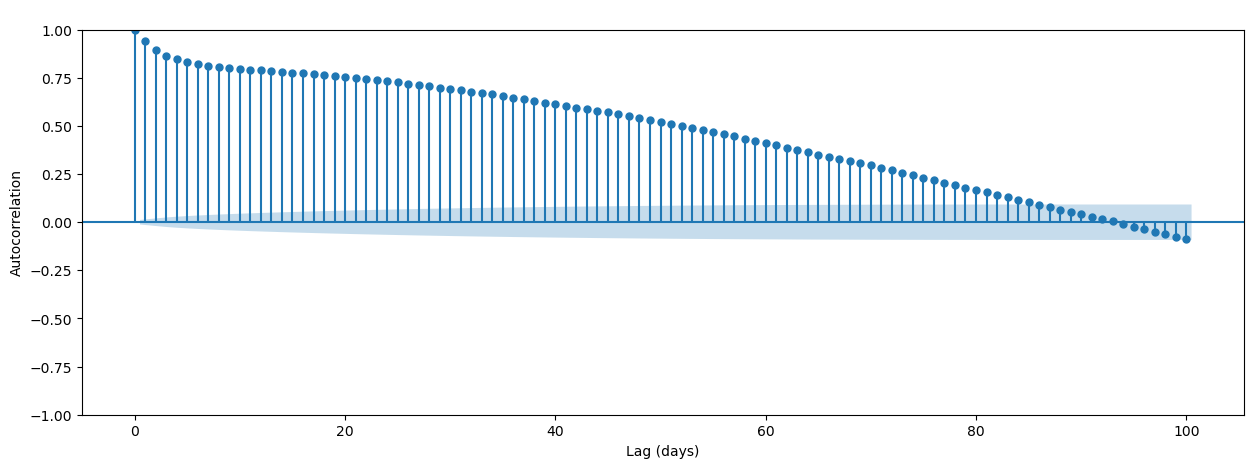

In [58]:
##Use plot_acf to plot autocorrelation plot (label variable)
#fig, ax = plt.subplots(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(15, 5))
#plot_acf(autocorr1, lags=30, title=' ', ax=ax)
plot_acf(autocorr1, lags=100, title=' ', ax=ax)
ax.set_xlabel("Lag (days)")
ax.set_ylabel("Autocorrelation")

#plt.savefig('Line autocorrelation (30 lags) Ensemble 5 London (2006-2080).png', dpi=80)
plt.savefig('Line autocorrelation (100 lags) Ensemble 5 London (2006-2080).png', dpi=80)
#plt.show()

In [59]:
##Create scatter plots to show correlation between y(t) and y(t-n)
##Create lagged label variables
label_col = ['TREFMXAV_U']
label_col_lag5 = [f+"_lag_5" for f in label_col]

In [60]:
##Ignore warnings
warnings.filterwarnings("ignore")

## Grab smaller subset of dataset (quicker)
df_ensemble5 = df_full.loc[df_full['Ensemble_num']==5]
df_ensemble5_copy = df_ensemble5.copy()
#display(df_ensemble5)

num_lags = 5
df_ensemble5_copy = lag_label(df_ensemble5_copy, num_lags)

In [61]:
##Checking adding 5 lag days has worked correctly - IT HAS!:)
assert np.array_equal(df_ensemble5_copy.loc["2006-01-07",:,:][label_col].values,
                      df_ensemble5_copy.loc["2006-01-12",:,:][label_col_lag5].values)

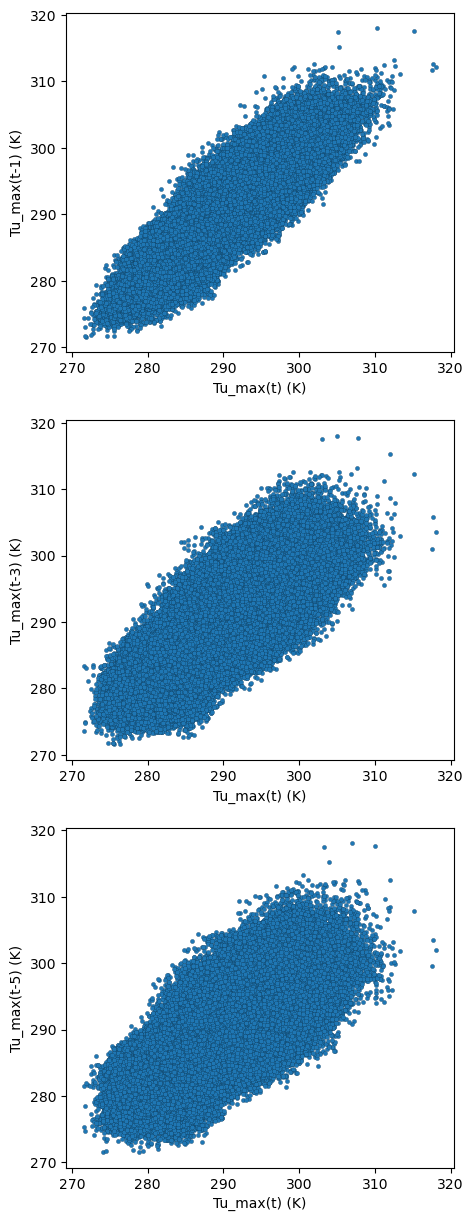

In [62]:
##Make subplot of autocorrelation of 1-, 3-, and 5-lag days
fig, axes = plt.subplots(nrows=3,figsize=(5, 15),sharey=True)
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='TREFMXAV_U_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='Tu_max(t-1) (K)', ax=axes[0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='TREFMXAV_U_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='Tu_max(t-3) (K)', ax=axes[1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='TREFMXAV_U_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='Tu_max(t-5) (K)', ax=axes[2])

fig.savefig('Ensemble 5 y(t) vs y(t-n) (2006-2080).png', bbox_inches = 'tight')

### Lagged covariates

In [63]:
feature_cols = ["FLNS", "FSNS", "PRECT", "PRSN", "QBOT", "TREFHT", "UBOT", "VBOT"]
feature_cols_lag5 = [f+"_lag_5" for f in feature_cols]

In [64]:
##Create scatter plots to show correlation between y(t) and X(t-n)
df_ensemble5_copy = df_ensemble5.copy()

##Set number of lags
num_lags = 5 #int
print("Number of lags:", num_lags)
df_ensemble5_copy = lag_pred(df_ensemble5_copy, num_lags)

Number of lags: 5


In [65]:
##Checking adding 5 lag days has worked correctly - IT HAS!:)
assert np.array_equal(df_ensemble5_copy.loc["2006-01-07",:,:][feature_cols].values,
                      df_ensemble5_copy.loc["2006-01-12",:,:][feature_cols_lag5].values)

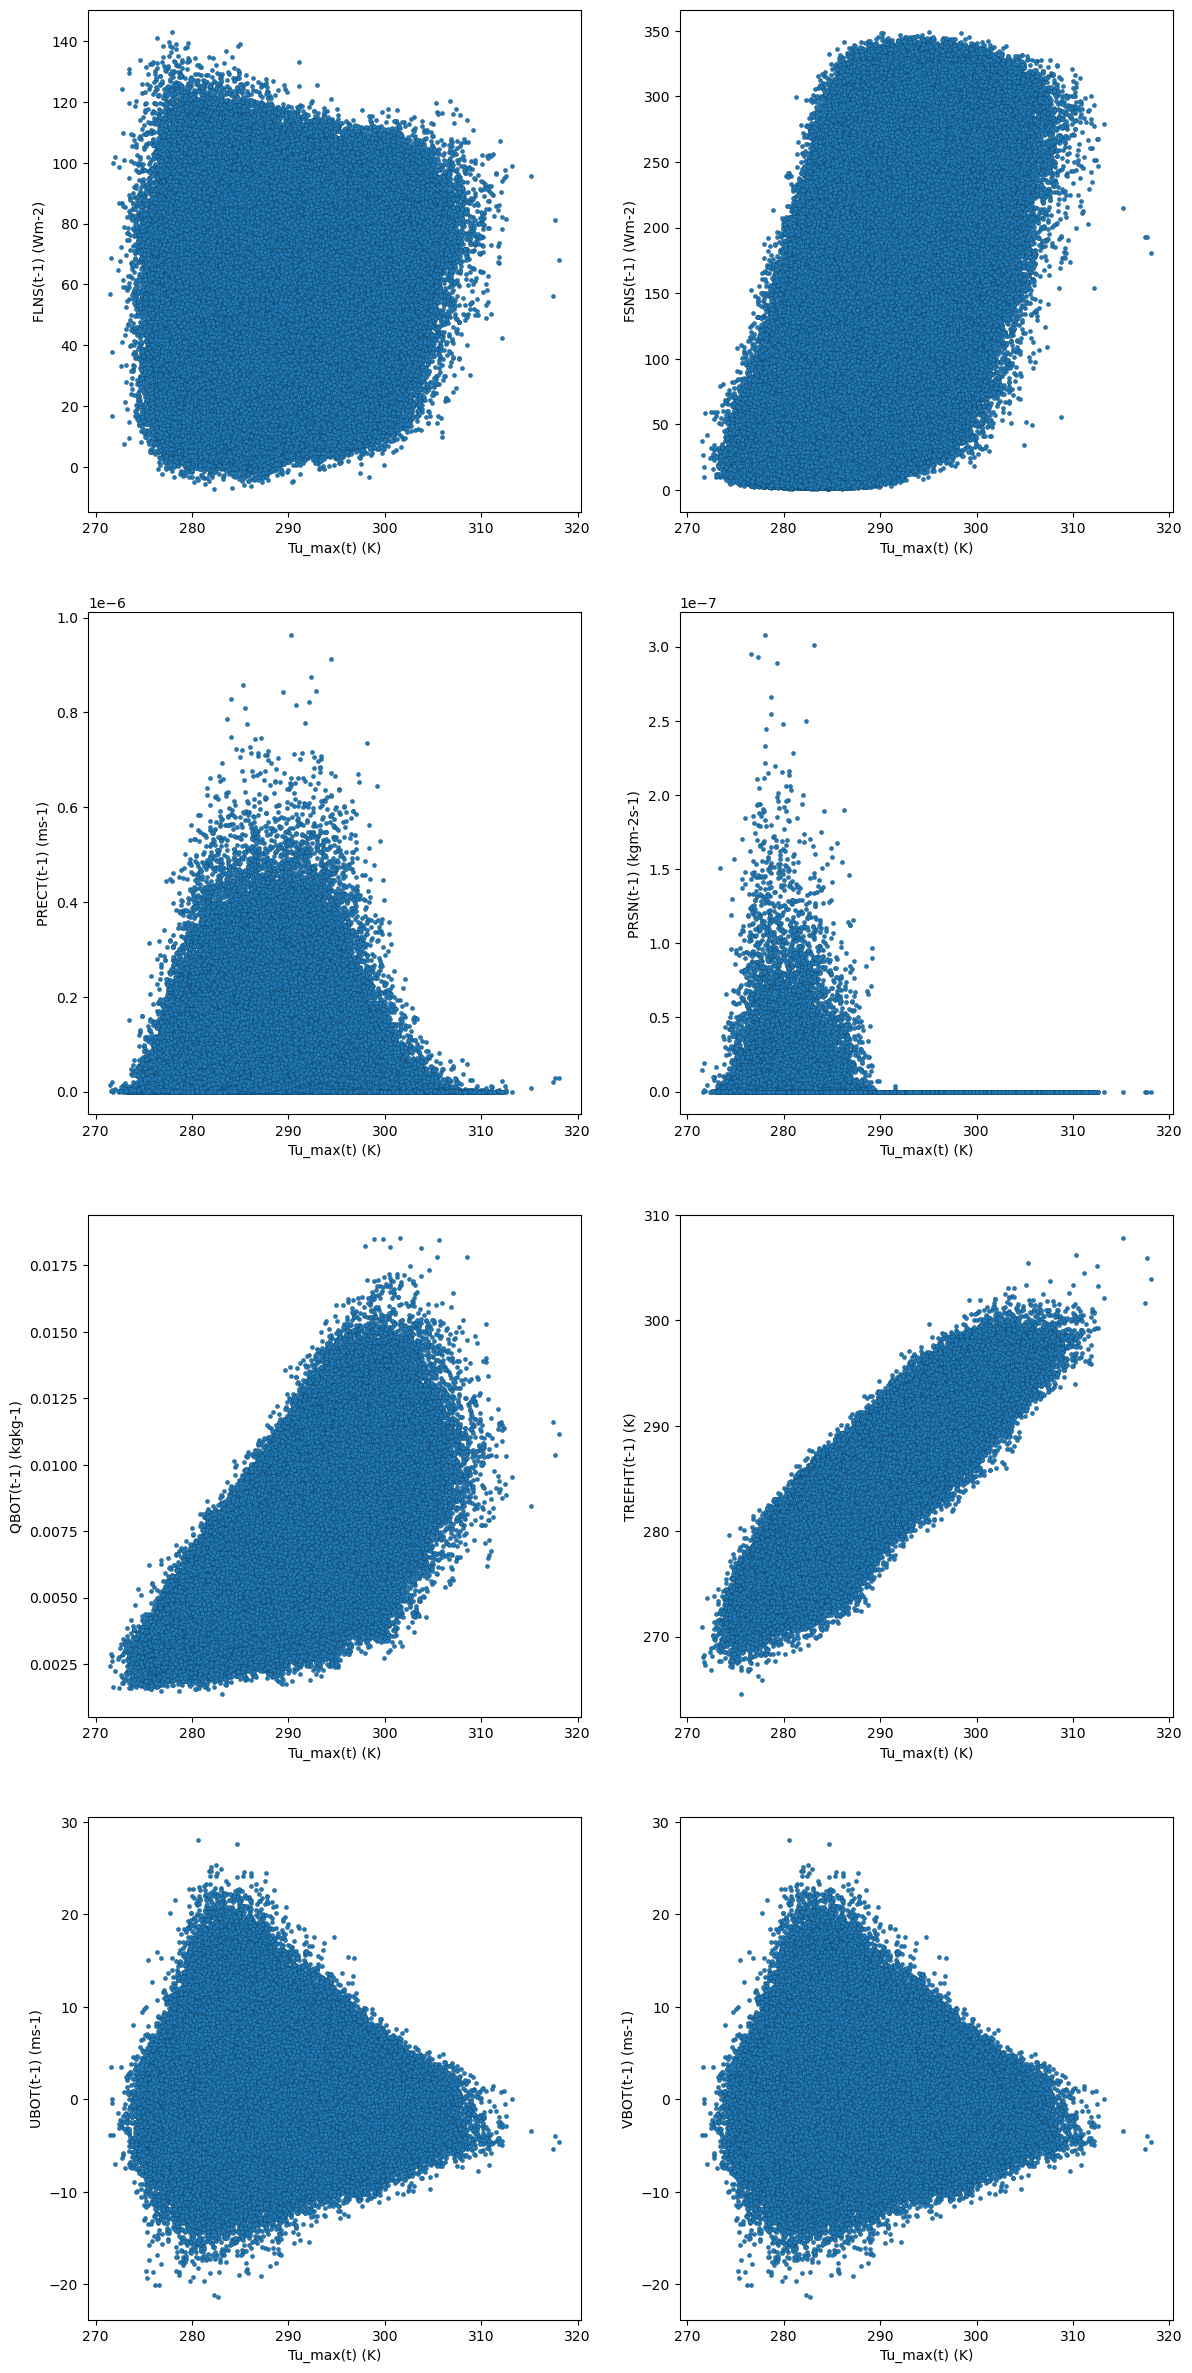

In [66]:
##Make subplot of laged covariates for 1-lag days
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 30))
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='FLNS_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='FLNS(t-1) (Wm-2)', ax=axes[0,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='FSNS_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='FSNS(t-1) (Wm-2)', ax=axes[0,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='PRECT_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='PRECT(t-1) (ms-1)', ax=axes[1,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='PRSN_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='PRSN(t-1) (kgm-2s-1)', ax=axes[1,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='QBOT_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='QBOT(t-1) (kgkg-1)', ax=axes[2,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='TREFHT_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='TREFHT(t-1) (K)', ax=axes[2,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='UBOT_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='UBOT(t-1) (ms-1)', ax=axes[3,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='UBOT_lag_1',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='VBOT(t-1) (ms-1)', ax=axes[3,1])

fig.savefig('Ensemble 5 y(t) vs X(t-1) (2006-2080).png', bbox_inches = 'tight')

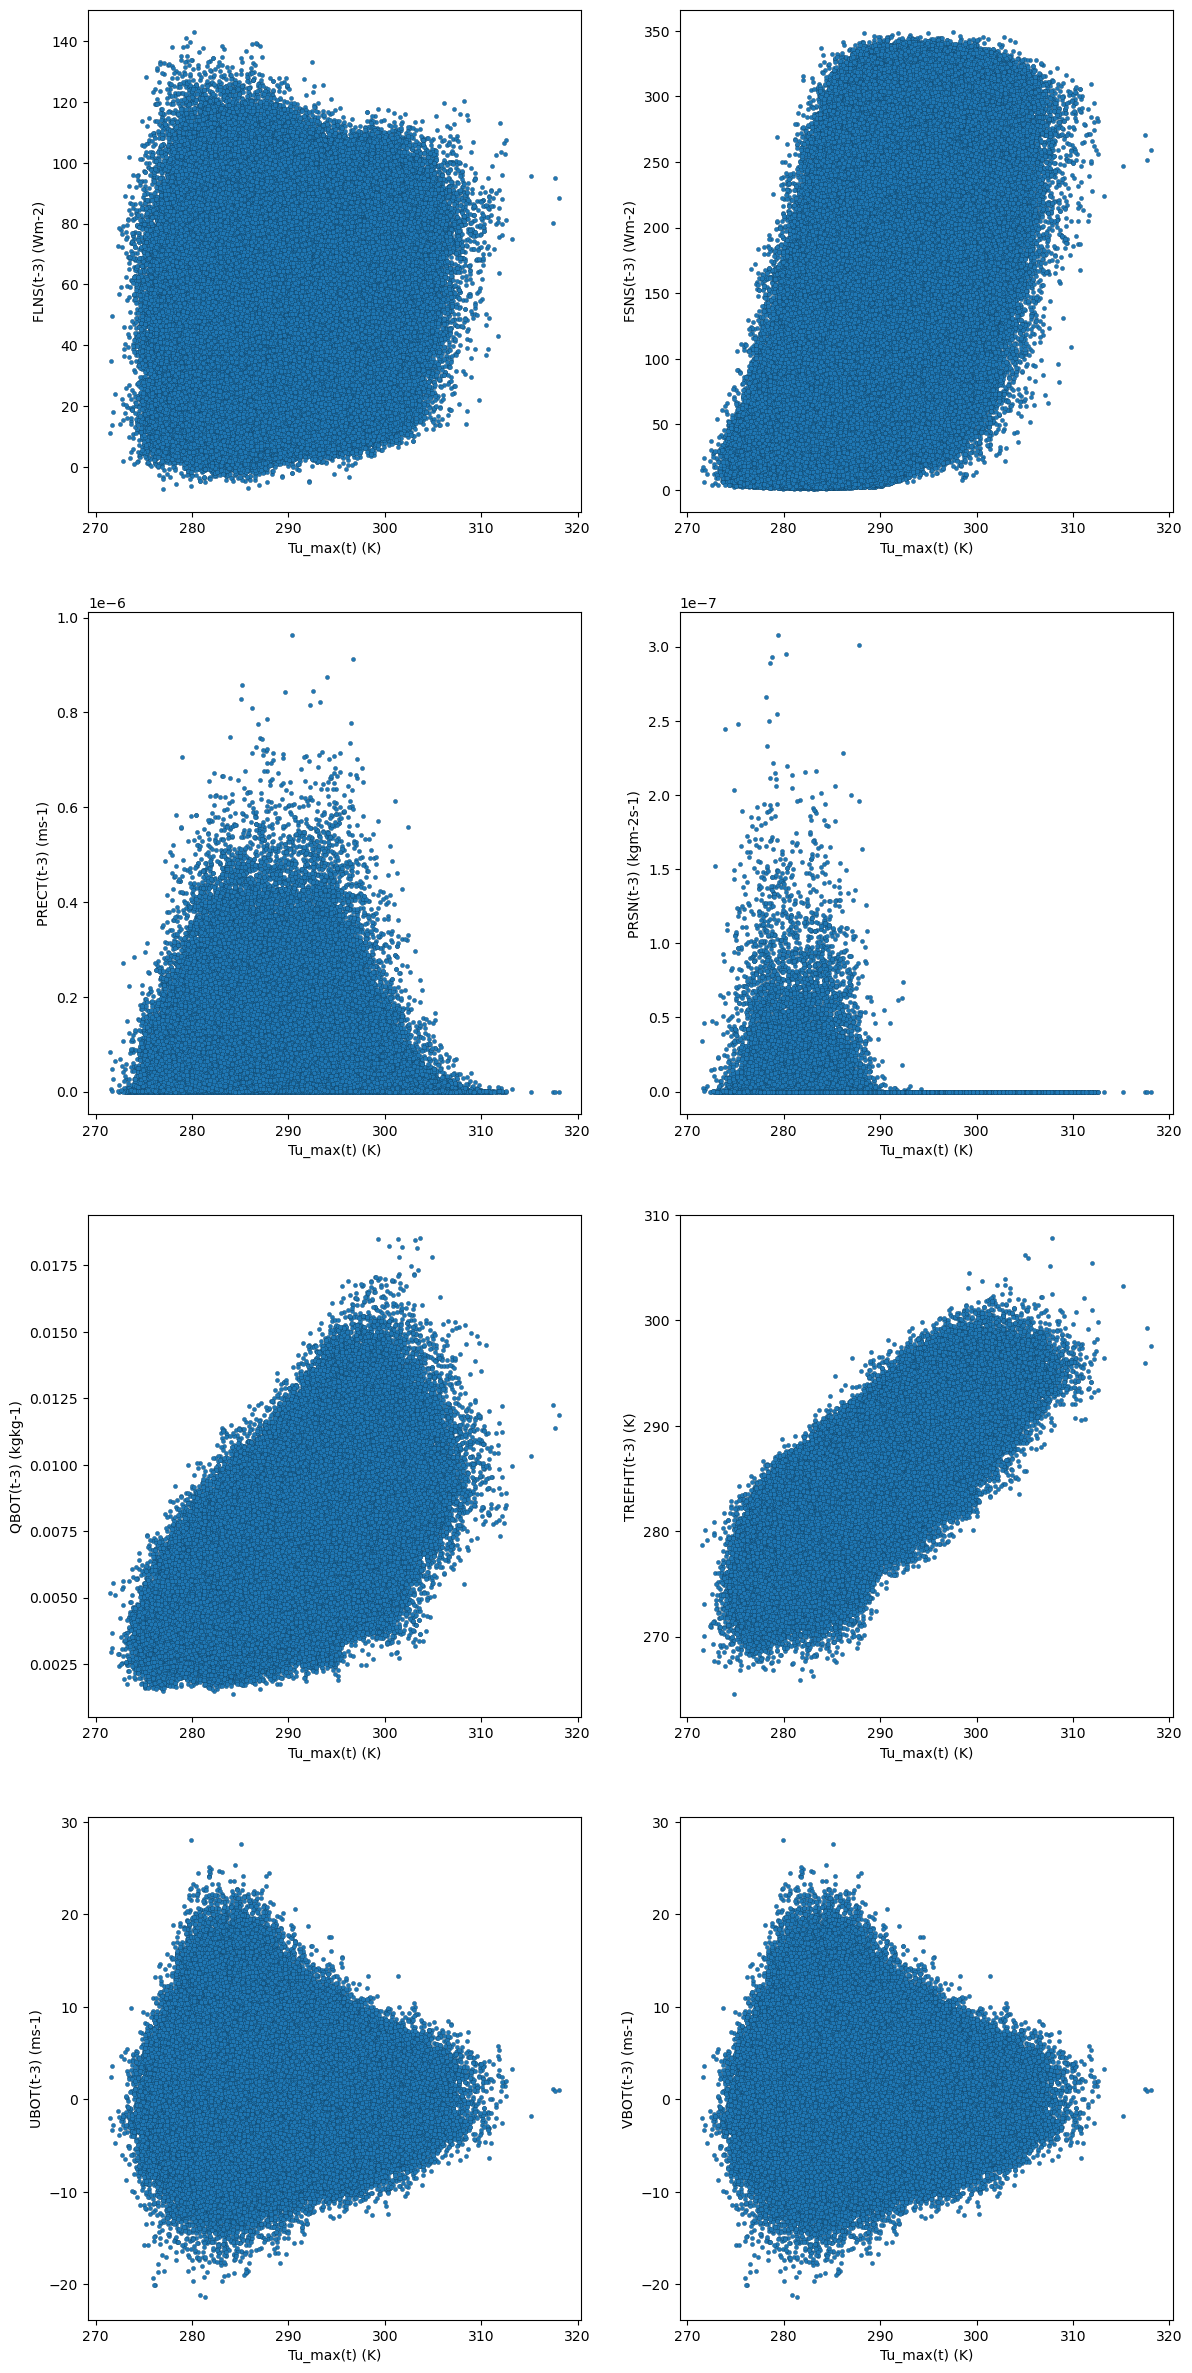

In [67]:
##Make subplot of laged covariates for 3-lag days
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 30))
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='FLNS_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='FLNS(t-3) (Wm-2)', ax=axes[0,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='FSNS_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='FSNS(t-3) (Wm-2)', ax=axes[0,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='PRECT_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='PRECT(t-3) (ms-1)', ax=axes[1,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='PRSN_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='PRSN(t-3) (kgm-2s-1)', ax=axes[1,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='QBOT_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='QBOT(t-3) (kgkg-1)', ax=axes[2,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='TREFHT_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='TREFHT(t-3) (K)', ax=axes[2,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='UBOT_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='UBOT(t-3) (ms-1)', ax=axes[3,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='UBOT_lag_3',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='VBOT(t-3) (ms-1)', ax=axes[3,1])

fig.savefig('Ensemble 5 y(t) vs X(t-3) (2006-2080).png', bbox_inches = 'tight')

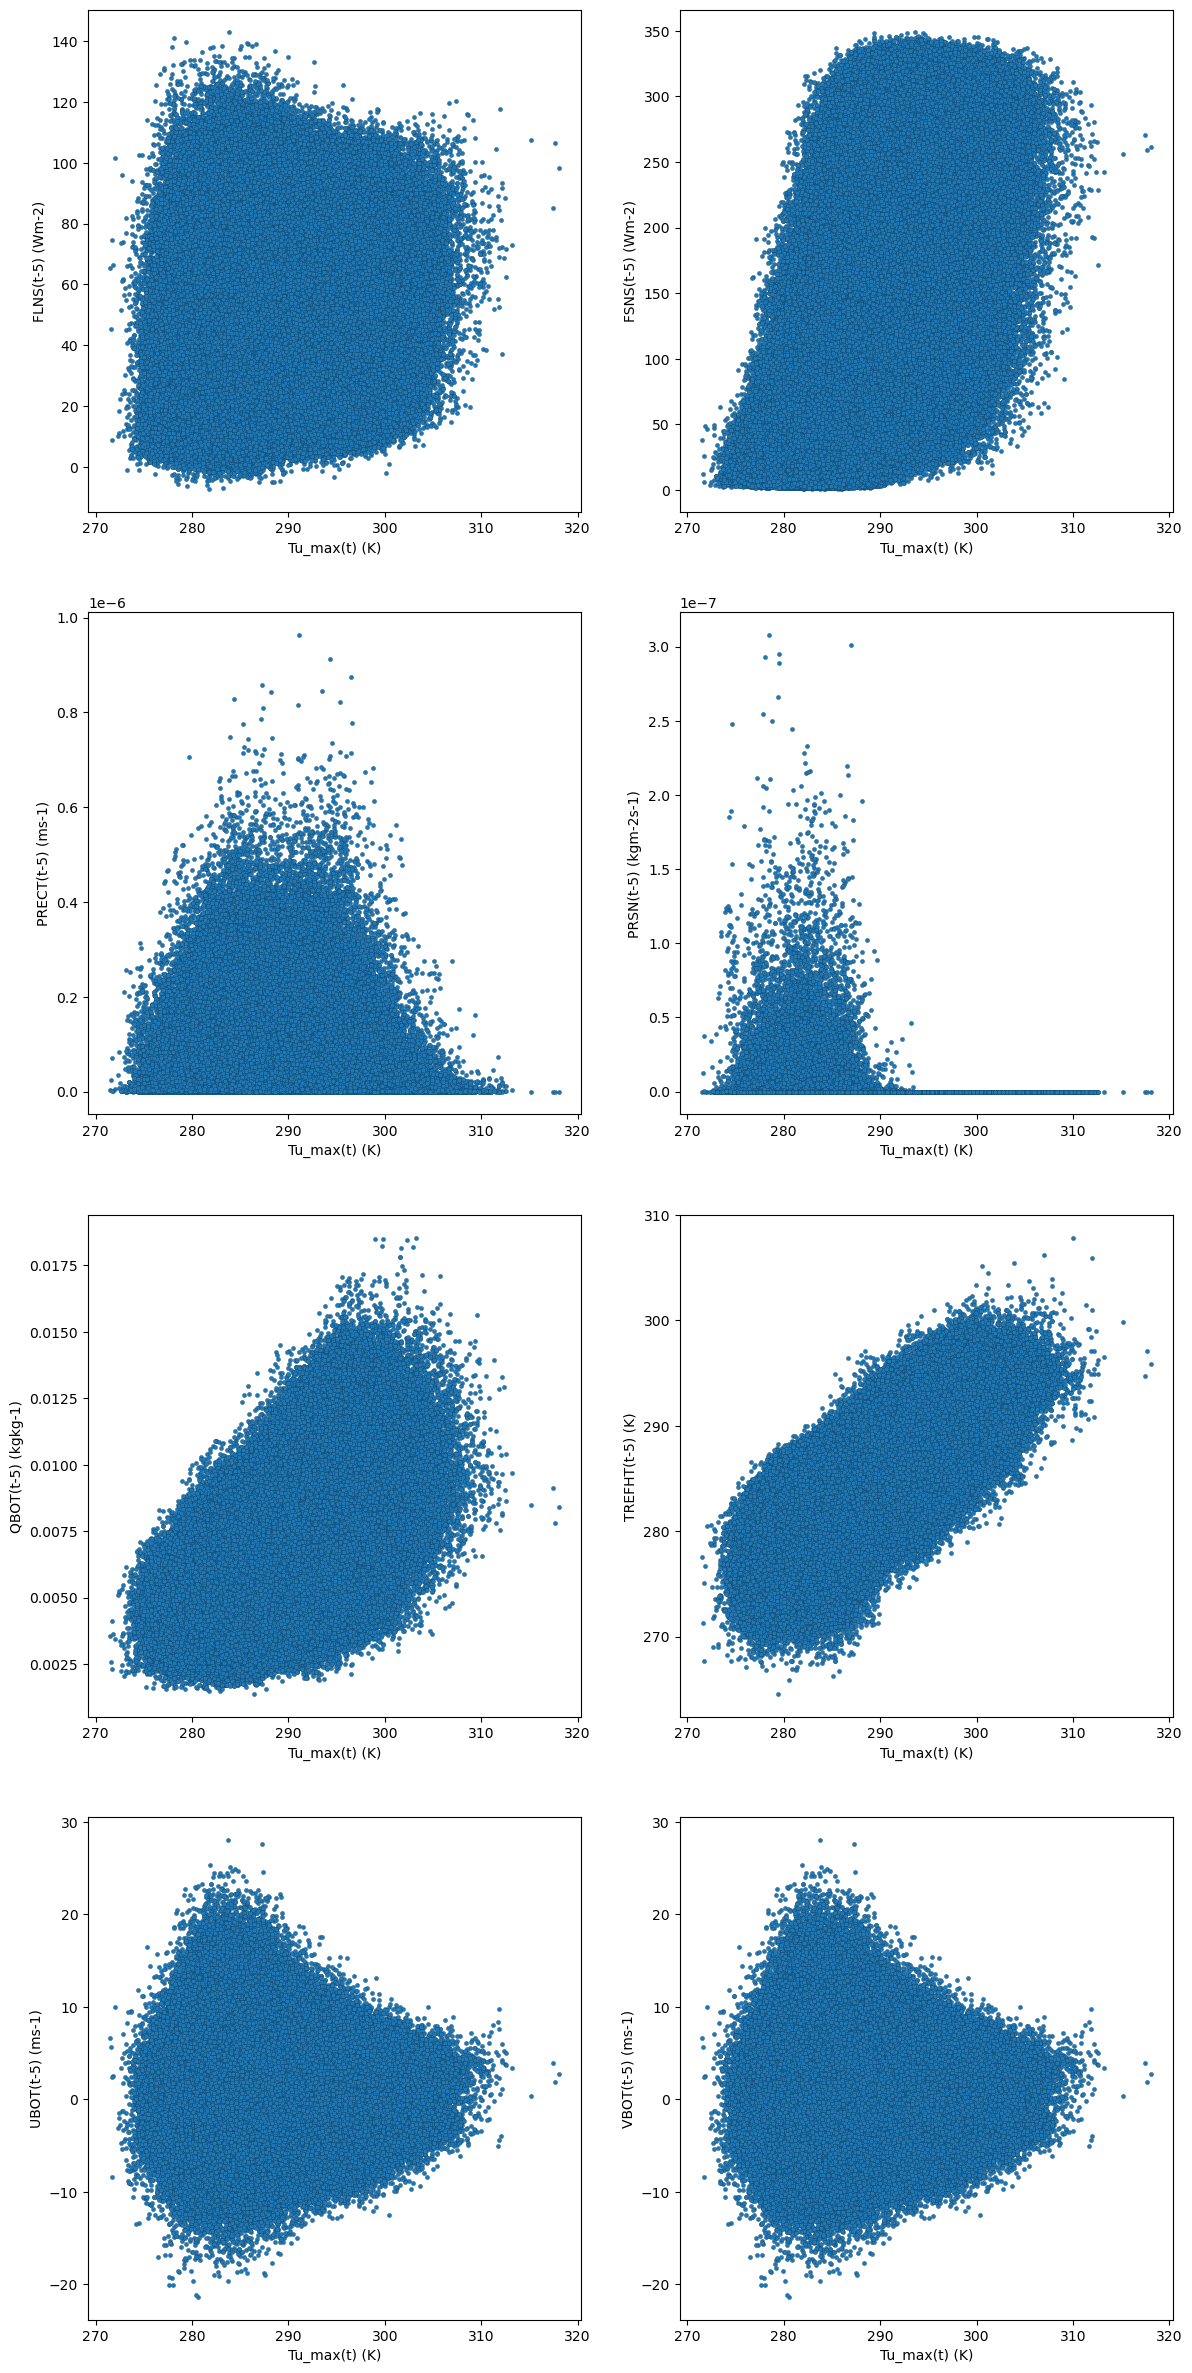

In [68]:
##Make subplot of laged covariates for 5-lag days
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 30))
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='FLNS_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='FLNS(t-5) (Wm-2)', ax=axes[0,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='FSNS_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='FSNS(t-5) (Wm-2)', ax=axes[0,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='PRECT_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='PRECT(t-5) (ms-1)', ax=axes[1,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='PRSN_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='PRSN(t-5) (kgm-2s-1)', ax=axes[1,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='QBOT_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='QBOT(t-5) (kgkg-1)', ax=axes[2,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='TREFHT_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='TREFHT(t-5) (K)', ax=axes[2,1])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='UBOT_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='UBOT(t-5) (ms-1)', ax=axes[3,0])
df_ensemble5_copy.plot.scatter(x='TREFMXAV_U',y='UBOT_lag_5',s=10, edgecolors='black', linewidth=0.1, xlabel='Tu_max(t) (K)', ylabel='VBOT(t-5) (ms-1)', ax=axes[3,1])

fig.savefig('Ensemble 5 y(t) vs X(t-5) (2006-2080).png', bbox_inches = 'tight')

# Calculating Correlation Coefficients with lagged covariates and autoregressive features

In [3]:
feature_cols = ["TREFMXAV_U", "FLNS", "FSNS", "PRECT", "PRSN", "QBOT", "TREFHT", "UBOT", "VBOT"]
feature_cols_lag5 = [f+"_lag_5" for f in feature_cols]

In [6]:
##Create scatter plots to show correlation between y(t) and X(t-n)
df_full_lagged = df_full.copy()

##Set number of lags
num_lags = 5 #int
print("Number of lags:", num_lags)
df_full_lagged = lag_pred(df_full_lagged, num_lags)

Number of lags: 5


In [8]:
##Checking adding 5 lag days has worked correctly - IT HAS!:)
assert np.array_equal(df_full_lagged.loc["2006-01-07",:,:][feature_cols].values,
                      df_full_lagged.loc["2006-01-12",:,:][feature_cols_lag5].values)

In [9]:
display(df_full_lagged.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44126628 entries, (Timestamp('2006-01-07 00:00:00'), 49.4764404296875, -1.25) to (Timestamp('2080-12-31 00:00:00'), 58.9005241394043, -3.75)
Data columns (total 57 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Ensemble_num      int64  
 1   TREFMXAV_U        float64
 2   Day_of_year       int64  
 3   Year              int64  
 4   FLNS              float64
 5   FSNS              float64
 6   PRECT             float64
 7   PRSN              float64
 8   QBOT              float64
 9   TREFHT            float64
 10  UBOT              float64
 11  VBOT              float64
 12  TREFMXAV_U_lag_1  float64
 13  TREFMXAV_U_lag_2  float64
 14  TREFMXAV_U_lag_3  float64
 15  TREFMXAV_U_lag_4  float64
 16  TREFMXAV_U_lag_5  float64
 17  FLNS_lag_1        float64
 18  FLNS_lag_2        float64
 19  FLNS_lag_3        float64
 20  FLNS_lag_4        float64
 21  FLNS_lag_5        float64
 22  FSNS_lag_1        float64
 

None

In [32]:
##Grab only label and 1-, 3-, 5- lagged autoregressive and covariate featurs, and make correlation matrix (cells not seaborn map)
df_full_lagged_cut = df_full_lagged[['TREFMXAV_U','TREFMXAV_U_lag_1','TREFMXAV_U_lag_3','TREFMXAV_U_lag_5',
                                    'FLNS_lag_1','FLNS_lag_3','FLNS_lag_5',
                                     'FSNS_lag_1','FSNS_lag_3','FSNS_lag_5',
                                     'PRECT_lag_1','PRECT_lag_3','PRECT_lag_5',
                                     'PRSN_lag_1','PRSN_lag_3','PRSN_lag_5',
                                     'QBOT_lag_1','QBOT_lag_3','QBOT_lag_5',
                                     'TREFHT_lag_1','TREFHT_lag_3','TREFHT_lag_5',
                                     'UBOT_lag_1','UBOT_lag_3','UBOT_lag_5',
                                     'VBOT_lag_1','VBOT_lag_3','VBOT_lag_5'
                                    ]]

df_full_lagged_cut = df_full_lagged_cut.rename(columns={'TREFMXAV_U': 'Tu_max', 'TREFMXAV_U_lag_1': 'Tu_max_lag_1', 'TREFMXAV_U_lag_3': 'Tu_max_lag_3', 'TREFMXAV_U_lag_5': 'Tu_max_lag_5'})
display(df_full_lagged_cut)

Tu_max  Tu_max_lag_1  Tu_max_lag_3  \
time       lat       lon                                            
2006-01-07 49.476440 -1.25  280.92432     282.19943     284.16670   
                      0.00  280.41270     281.76422     284.29090   
                      1.25  279.97565     281.07074     284.27728   
           50.418850 -5.00  282.86203     283.30084     284.69930   
                     -3.75  282.48340     283.30164     284.88394   
...                               ...           ...           ...   
2080-12-31 57.958115 -6.25  281.49220     284.12827     285.10867   
                     -3.75  280.94980     283.16440     285.11660   
                     -2.50  281.72986     283.04514     285.59033   
                     -1.25  282.41420     282.90662     285.85873   
           58.900524 -3.75  282.37146     284.78027     285.95578   

                            Tu_max_lag_5  FLNS_lag_1  FLNS_lag_3  FLNS_lag_5  \
time       lat       lon                                                       
2006-01-07 49.476440 -1.25     283.67900   30.611773   15.579892   78.309050   
                      0.00     283.35100   20.055420   10.273605   60.172768   
                      1.25     282.18738   15.253036    6.504934   32.727840   
           50.418850 -5.00     284.44394   30.513916   24.176336   78.301250   
                     -3.75     284.32986   28.612446   23.783995   82.156400   
...                                  ...         ...         ...         ...   
2080-12-31 57.958115 -6.25     284.52765   41.750000   26.625000   44.750000   
                     -3.75     282.62793   24.000000   15.312500   22.875000   
                     -2.50     283.38464   47.250000   22.750000   68.500000   
                     -1.25     284.18097   58.000000   21.875000   80.000000   
           58.900524 -3.75     285.41013   51.000000   21.750000   64.000000   

                            FSNS_lag_1  FSNS_lag_3  FSNS_lag_5  ...  \
time       lat       lon                                        ...   
2006-01-07 49.476440 -1.25   20.675766   13.837377   49.704235  ...   
                      0.00   20.671724   14.637919   43.689503  ...   
                      1.25    8.839799   15.506983   28.623762  ...   
           50.418850 -5.00   14.789470   13.396733   44.980167  ...   
                     -3.75   13.436783   21.152870   46.794003  ...   
...                                ...         ...         ...  ...   
2080-12-31 57.958115 -6.25    9.485840    4.489746    6.656860  ...   
                     -3.75    5.708374    4.724365    8.070312  ...   
                     -2.50    7.190430    5.576660   12.765137  ...   
                     -1.25    6.166016    7.282104   12.911621  ...   
           58.900524 -3.75    9.446533    2.393799    8.010742  ...   

                            QBOT_lag_5  TREFHT_lag_1  TREFHT_lag_3  \
time       lat       lon                                             
2006-01-07 49.476440 -1.25    0.005410     281.31842     283.25670   
                      0.00    0.005415     280.44058     282.51570   
                      1.25    0.005343     279.30045     282.06900   
           50.418850 -5.00    0.005035     282.49493     283.90760   
                     -3.75    0.005278     282.29230     283.71548   
...                                ...           ...           ...   
2080-12-31 57.958115 -6.25    0.005737     282.87500     284.62500   
                     -3.75    0.004730     280.75000     283.37500   
                     -2.50    0.004730     281.37500     284.37500   
                     -1.25    0.004395     282.25000     284.50000   
           58.900524 -3.75    0.005035     283.25000     284.87500   

                            TREFHT_lag_5  UBOT_lag_1  UBOT_lag_3  UBOT_lag_5  \
time       lat       lon                                                       
2006-01-07 49.476440 -1.25     281.38837   -4.763804    3.023966    5.109643   
                 

In [42]:
##Calculate correlation matrix
corr3 = df_full_lagged_cut.corr(method='spearman')
display(corr3.style.background_gradient(cmap='coolwarm'))

### Calculating numerical autocorrelation

In [3]:
label_col = ["TREFMXAV_U"]
label_col_lag30 = [f+"_lag_30" for f in label_col]

In [7]:
##Create scatter plots to show correlation between y(t) and X(t-n)
df_full_lagged2 = df_full.copy()

##Set number of lags
num_lags = 30 #int
print("Number of lags:", num_lags)
df_full_lagged2 = lag_label(df_full_lagged2, num_lags)

Number of lags: 30


In [10]:
##Checking adding 30 lag days has worked correctly - IT HAS!:)
assert np.array_equal(df_full_lagged2.loc["2006-02-01",:,:][label_col].values,
                      df_full_lagged2.loc["2006-03-03",:,:][label_col_lag30].values)

In [14]:
autoregressive_30_corr = df_full_lagged2.drop(columns=['Ensemble_num','Day_of_year','Year','FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT']).corr(method='spearman')

display(autoregressive_30_corr)

TREFMXAV_U  TREFMXAV_U_lag_1  TREFMXAV_U_lag_2  \
TREFMXAV_U           1.000000          0.929361          0.883621   
TREFMXAV_U_lag_1     0.929361          1.000000          0.929361   
TREFMXAV_U_lag_2     0.883621          0.929361          1.000000   
TREFMXAV_U_lag_3     0.860157          0.883621          0.929360   
TREFMXAV_U_lag_4     0.844381          0.860157          0.883621   
TREFMXAV_U_lag_5     0.832372          0.844381          0.860157   
TREFMXAV_U_lag_6     0.822961          0.832372          0.844381   
TREFMXAV_U_lag_7     0.815603          0.822961          0.832372   
TREFMXAV_U_lag_8     0.809642          0.815603          0.822962   
TREFMXAV_U_lag_9     0.804570          0.809642          0.815604   
TREFMXAV_U_lag_10    0.800157          0.804570          0.809642   
TREFMXAV_U_lag_11    0.796217          0.800157          0.804570   
TREFMXAV_U_lag_12    0.792455          0.796217          0.800157   
TREFMXAV_U_lag_13    0.788823          0.792455          0.796217   
TREFMXAV_U_lag_14    0.785299          0.788823          0.792456   
TREFMXAV_U_lag_15    0.781587          0.785299          0.788823   
TREFMXAV_U_lag_16    0.777695          0.781587          0.785298   
TREFMXAV_U_lag_17    0.773527          0.777695          0.781587   
TREFMXAV_U_lag_18    0.769180          0.773527          0.777695   
TREFMXAV_U_lag_19    0.764610          0.769180          0.773527   
TREFMXAV_U_lag_20    0.759891          0.764610          0.769180   
TREFMXAV_U_lag_21    0.755021          0.759891          0.764611   
TREFMXAV_U_lag_22    0.749895          0.755021          0.759892   
TREFMXAV_U_lag_23    0.744683          0.749896          0.755022   
TREFMXAV_U_lag_24    0.739328          0.744684          0.749897   
TREFMXAV_U_lag_25    0.733960          0.739328          0.744685   
TREFMXAV_U_lag_26    0.728340          0.733960          0.739329   
TREFMXAV_U_lag_27    0.722390          0.728340          0.733961   
TREFMXAV_U_lag_28    0.716374          0.722391          0.728340   
TREFMXAV_U_lag_29    0.710196          0.716375          0.722391   
TREFMXAV_U_lag_30    0.703783          0.710197          0.716375   

                   TREFMXAV_U_lag_3  TREFMXAV_U_lag_4  TREFMXAV_U_lag_5  \
TREFMXAV_U                 0.860157          0.844381          0.832372   
TREFMXAV_U_lag_1           0.883621          0.860157          0.844381   
TREFMXAV_U_lag_2           0.929360          0.883621          0.860157   
TREFMXAV_U_lag_3           1.000000          0.929360          0.883621   
TREFMXAV_U_lag_4           0.929360          1.000000          0.929360   
TREFMXAV_U_lag_5           0.883621          0.929360          1.000000   
TREFMXAV_U_lag_6           0.860157          0.883621          0.929360   
TREFMXAV_U_lag_7           0.844382          0.860157          0.883621   
TREFMXAV_U_lag_8           0.832372          0.844382          0.860158   
TREFMXAV_U_lag_9           0.822962          0.832373          0.844383   
TREFMXAV_U_lag_10          0.815604          0.822962          0.832373   
TREFMXAV_U_lag_11          0.809642          0.815604          0.822962   
TREFMXAV_U_lag_12          0.804570          0.809642          0.815604   
TREFMXAV_U_lag_13          0.800157          0.804570          0.809643   
TREFMXAV_U_lag_14          0.796217          0.800158          0.804570   
TREFMXAV_U_lag_15          0.792456          0.796217          0.800158   
TREFMXAV_U_lag_16          0.788823          0.792456          0.796217   
TREFMXAV_U_lag_17          0.785298          0.788823          0.792455   
TREFMXAV_U_lag_18          0.781587          0.785298          0.788822   
TREFMXAV_U_lag_19          0.777695          0.781587          0.785298   
TREFMXAV_U_lag_20          0.773528          0.777695          0.781587   
TREFMXAV_U_lag_21          0.769181          0.773528          0.777696   
TREFMXAV_U_lag_22          0.764611          0.769182          0.773529   
TREFMXAV_U